# Sources of non-additivity at the community level

In this notebook we run in silico multiple-stressor experiments with a very simple ecological model. Our purpose is to explain how species turnover (extinctions and invasions) is a biological source of non-additivity and we explain how different community metrics will observe non-additivity between the same stressors in different ways. 


### Contents  <a class="anchor" id="1"></a>
* [Figure 3 - Observational Effects](#2)
* [Figure 4 - Distance-Function](#3)
* [Figure 5 - Diversity](#4)
* [Sup. Figure - Intensity](#5)
* [Sup. Figure - Distance-Diversity](#6)

### Packages and Functions 

In [1]:
# General use
import numpy as np
from numpy.linalg import eig, norm, inv                                
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint                                      # Solves a system of ODEs
#from scipy import stats                                                 # For pearson's correlation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap   # For colour gradients
#import statistics                                                       # For mode
from scipy.stats import spearmanr                                       # Spearman rank correlation

In [2]:
# Function to create a Lotka Voltera Vector Field that takes:

#    N        = Vector of biomasses 
#    t        = Time 
#    Aij      = Interaction matrix 
#    rho      = Carrying capacities 

##############################################################

def field(N,t,Aij,rho):                           
    thresh = 1e-10                              # Threshold biomass below which a species is extinct
    limit = 500                                 # Limit to biomass - indicates divergence model (not interesting)
    D=np.diag(N/abs(rho))                       # Creating a diagonal matrix with abundances divided by rho 
    vect_N = np.dot(D,rho-N+np.dot(Aij,N))      # Lotka-Voltera equation
    
    ### Extinction threshhold, species can't have negative biomass (set extinct species to 0.. setting to thresh can cause some weird glitches when investigating invasions)
    extinct=np.where(N<thresh)[0]                    
    vect_N[extinct]=np.maximum(vect_N[extinct], 0) 
                            
    ### Divergence threshold - Not relevant because we're using the while loops? ###
    #divergent=np.where(N>limit)[0]                     # Divergence threhold - stops species have very large values 
    #vect_N[divergent]=np.zeros(len(divergent))         # Setting biomass of divergent species to 0 
    
    return vect_N                                      # Return a vector made up of the changes in N over time

In [3]:
# Function to generate a pool of species (not all will co-exist) that takes:
# Modified so thatthe exact fraction of potential invaders can be forced

#    S        = Number of Speices 
#    mu       = Mean interaction strength
#    sigma    = Spread of interaction strengths 
#    zeta     = Scales carrying capacity (larger values give more uneven biomass distributions)
#    cen      = Controls the center of the biomass distribution (0 means roughly 50% of species in pool will assemble)
#    inv_frac = The fraction of potential invaders in the community (0.5 means equal number of invaders and assembled)


##############################################################

def random_assembly_frac(S, mu, sigma, zeta, cen, inv_frac):            
    thresh = 1e-10                                # Threshold biomass below which a species is extinct
    limit = 500                                   # Limit to biomass - indicates divergence phase of model (not interesting to us)
    tmax = 30*np.sqrt(S)                          # Maximum time (function of S)
    t= np.linspace(0, tmax,int(100*tmax))         # Timeframe (resolution function of tmax) 
    
    
    ### Option to force the community to the correction fraction of invaders ###
    incorrect_fraction = True 
    while incorrect_fraction == True:
        
        ### To prevent model divergences
        divergence = True                                                  
        while divergence == True:                                          

            # Drawing rho (carrying capacity) centered on cen and scaled by zeta 
            rho = np.random.normal(0, 1, size = S)*zeta + cen              

            # Drawing Aij (interaction matrix) interaction strengths scaled by number of species. Diagonals set to 0. 
            Aij = mu/S+sigma/np.sqrt(S)*np.random.normal(0, 1, size = (S, S))    
            Aij = Aij - np.diag(np.diag(Aij))                              

            # Intial biomasses (all positive)
            N0=0.01*np.random.uniform(0, 1, size = S)                      

            # Dynamics - odeint solves the differential equations that are created using the field function (Lotka Voltera)
            Nt=odeint(field, N0, t, args=(Aij, rho))                      
            Nf=Nt[-1,:]                                                   

            # Divergence control (repeat loop if some species biomass is too large)
            if max(Nf) < limit:                                           
                divergence = False
            else:
                print("Divergence")

        # Identify persisting and extinct species (based on biomass and rate of biomass change)
        rates=field(Nf, tmax, Aij, rho)/Nf                                       # Rates of change of biomass
        persist = np.where((Nf > thresh)&(rates>np.log(thresh)/(20*tmax)))[0]    # List of persisting species - to persist a species must have biomass above threshold AND not be trending towards extinction
        s = len(persist)                                                         # Number of persisting species
        Aij_p = Aij[persist, :][:, persist]                                      # Interaction matrix of persisting species
        extinct = np.where(Nf < thresh)[0]                                       # List of extinct species 

        # draw biomass of extinct species so that they are above 0 (to avoid gliches in odeint)
        Nf[extinct] = np.random.uniform(thresh/2,thresh, size=len(extinct))*np.ones(len(extinct))              

        # Use environmental sensitivity matrix to make species that were heading towards equilibrium to go straight to equilibrium. Nf is definitely equilibrium now.
        Nf[persist] = np.dot(inv(np.eye(s) - Aij_p), rho[persist])                
    
    
        # Calculate the fraction of potential invaders 
        frac = len(extinct) / (len(extinct) + len (persist))
        
        # Complete loop if this fraction is what was requested 
        if frac == inv_frac:
            incorrect_fraction = False
   
    
    return rho, Aij, Nf, persist, extinct

In [4]:
##### Aggregate Properties 


#########         Shannon diversity index        ###############
# Entropy of the system 
# Only consider species with positive biomass (as 0s give you a nan)
# Biomass = A vector containing species biomass (at a certain timepoint)

def entropy(biomass):
    positives = np.where(biomass > 1e-10)
    p = biomass[positives]/sum(biomass[positives])
    return np.exp(-sum(p*np.log(p)))


#########             Hills number              #################

# Only consider species with positive biomass (as 0s give you a nan)
# Biomass = A vector containing species biomass (at a certain timepoint)
# q refers to the "order" of Hill number. Hill numbers of order q or effective number of species
# Chosing q = 1 or 0 gives me issues. But any other number is working fine

def hill(biomass, hill_n):
    q = hill_n
    positives = np.where(biomass > 1e-10)
    p = biomass[positives]/sum(biomass[positives])
    return np.power(norm(p, q), q/(1.-q))


#########        Simpson diversity index       #################
# The probability that two entities taken at random are the same type
# Only consider species with positive biomass (as 0s give you a nan)
# Biomass = A vector containing species biomass (at a certain timepoint)

def simp_inv(biomass):
    positives = np.where(biomass > 1e-10)
    p = biomass[positives]/sum(biomass[positives])
    if sum(p*p) == 0:
        return 0
    else:
        return 1/sum(p*p)


In [5]:
# Function to run multiple-stressor in silico experiments that takes: 

#    num_stress      = The number of multiple stressor experiments to run per community
#    S               = Number of species in the species pool (for each community)
#    zeta            = Controls biomass distribution (for each community)
#    cen             = Controls the center of the biomass distribution (0 means 50% of species in pool will assemble)
#    mu              = Mean interaction strength (for each community)
#    sigma           = Spread of interaction strengths (for each community)
#    system          = If "closed", the system is closed to invasions, otherwise invasions can occur 
#    Type_I          = If "neg"/"pos"/"no", then type I effects are always negative/positive/excluded. Otherwise, they are mixed 
#    sI_d            = The direction/bias of stressors. Set as 0 if Type_I is pos or neg. 
#    sI_i            = The intensity of the type I effects (for both stressors)
#    Type_I_rel      = If "true", stressors are relative to rho, otherwise stressors are independent of rho
#    inv_frac        = Fraction of invaders - e.g. 0.5

##############################################################

def stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,
                        Type_I, sI_d, sI_i, Type_I_rel, 
                        inv_frac):
    
    ############ Initial Checks ################# 
    
    print("S: ", S)
    print("zeta: ", zeta)
    print("cen: ", cen)
    print("mu: ", mu)
    print("sigma: ", sigma)
    if system == "closed":    
        print("System: Closed")
    else: 
        print("System: Open")
    print("")    
    if Type_I == "neg": 
        print("Type I: Negative")
        print("Type_I Direction:",sI_d,"+- 1")  
        print("Type_I Intensity: 0 to",sI_i)  
    elif Type_I == "pos": 
        print("Type I: Positive")
        print("Type_I Direction:",sI_d,"+- 1")  
        print("Type_I Intensity: 0 to",sI_i)  
    elif Type_I == "no": 
        print("Type I: None")
    else: 
        print("Type I: Mixed")
        print("Type_I Direction:",sI_d,"+- 1")  
        print("Type_I Intensity: 0 to",sI_i)  
    if Type_I_rel == "true":
        print("Type I relative to rho")
    print("")    
    print("Number of stressor experiments per community: ", num_stress)
    print("")

    
    
    ### Generate community
    rho, Aij, Nf, persist, extinct = random_assembly_frac(S, mu, sigma, zeta, cen, inv_frac)
        
    #### option to close to invasion
    # need to rename S to s so that I don't keep changing the input to random_assembly
    if system == "closed":
        rho = rho[persist]
        Aij = Aij[persist, :][:, persist]
        Nf = Nf[persist]
        s = len(persist)        
    else:
        s = S  

    print("Persisting species: ", len(persist),"/",S)
    print("")
        
    ################## Loop to run stressor simulations on each community ###################

    # Defining vectors to be filled 
    Non_add_rel=np.zeros(num_stress)                          
    Non_add_abs=np.zeros(num_stress)
    Synergism_rel=np.zeros(num_stress)                         
    Synergism_abs=np.zeros(num_stress)  
    Synergism_rich_abs = np.zeros(num_stress)
    Synergism_diversity_abs = np.zeros(num_stress)
    Synergism_total_abs = np.zeros(num_stress)
    Synergism_simp_abs = np.zeros(num_stress)
    Ext_1 = np.zeros(num_stress)
    Ext_2 = np.zeros(num_stress)
    Ext_12 = np.zeros(num_stress)
    Inv_1 = np.zeros(num_stress)
    Inv_2 = np.zeros(num_stress)
    Inv_12 = np.zeros(num_stress)
    intensity = np.zeros(num_stress)
    s1_intensities = np.zeros(num_stress)
    s2_intensities = np.zeros(num_stress)
    cos_s12 = np.zeros(num_stress)
    min_cos = np.zeros(num_stress)
    mean_cos = np.zeros(num_stress)
    max_cos = np.zeros(num_stress)
    Non_add_rich = np.zeros(num_stress)
    Non_add_diversity = np.zeros(num_stress)
    Non_add_total = np.zeros(num_stress)
    Non_add_simp = np.zeros(num_stress)
    syn_hill_2 = np.zeros(num_stress)
    syn_hill_3 = np.zeros(num_stress)
    syn_hill_4 = np.zeros(num_stress)
    syn_hill_5 = np.zeros(num_stress)
    syn_hill_6 = np.zeros(num_stress)
    syn_hill_7 = np.zeros(num_stress)
    syn_hill_8 = np.zeros(num_stress)
    syn_hill_9 = np.zeros(num_stress)
    syn_hill_10 = np.zeros(num_stress)
    
    hill_n_2 = 2.0
    hill_n_3 = 1.75
    hill_n_4 = 1.5
    hill_n_5 = 1.25
    hill_n_6 = 1.01
    hill_n_7 = 0.75
    hill_n_8 = 0.5
    hill_n_9 = 0.25
    hill_n_10 = 0.01
            

    # Settings for dynamical models 
    #t = np.linspace(0, 500, 100)              # Time (start, finish, resolution)
    thresh = 1e-10                            # Threshold biomass below which a species is extinct (if this is large there can be some artificial synergism)
    #limit = 500                               # Limit to biomass - biomass above this indicates the model has entered a divergent phase (not biologically interesting)
        
        
    ### Actual loop to run "num_stress" stressor expeirments on each community
    for n in range(num_stress):               

        ########## Generate Stressors ##########

        ##### Stressor 1 #####
        s1 = np.random.normal(sI_d, 1, size=s)      # Draw stressor 2 from a random normal distribution
        s1 = s1/norm(s1)                            # Normalise so that changing direction does not change intensity
        s1_int = np.random.uniform(0, sI_i)         # Intensity value to scale entire stressor vector by 
        
        if Type_I_rel == "true":
            s1 = s1 * s1_int * abs(rho)             # Stressors proportional to growth rates
        else: 
            s1 = s1 * s1_int * norm(rho)            # Stressors NOT proportional to growth rates (but scaled by abundance distribution)
        
        if Type_I == "neg":                         # IF user decides to only use negative stressors
            s1 = abs(s1)                            # Make stressor have all positive values 
        elif Type_I == "pos":                       # OR IF user decides to only use positive stressors
            s1 = np.negative(abs(s1))               # Make stressor have all negative values 
        else:                                       # OTHERWISE
            s1 = s1                                 # Leave it as is 


        ##### Stressor 2 #####
        s2 = np.random.normal(sI_d, 1, size=s)                       
        s2 = s2/norm(s2)                            
        s2_int = np.random.uniform(0, sI_i)     
        
        if Type_I_rel == "true":
            s2 = s2 * s2_int * abs(rho)                
        else: 
            s2 = s2 * s2_int * norm(rho)               
        
        if Type_I == "neg":                         
            s2 = abs(s2)                           
        elif Type_I == "pos":                      
            s2 = np.negative(abs(s2))             
        else:                                      
            s2 = s2    
                    

        ########## Apply Stressors ##########       
        ### Nf is the equalibrium biomass before stressors
        ### NS is the equalibrium biomass after stressors 
        ### We are scaling up predictions from the species to the community (part of the Compositional Null Model)
                   
        Nf = np.maximum(rho, 0)
        NS_1 = np.maximum((rho - s1), 0)
        NS_2 = np.maximum((rho - s2), 0)
        NS_12 = np.maximum((rho - (s1+s2)), 0)
                
            
 
        # Change in biomass 
        DN_1 = NS_1 - Nf       
        DN_2 = NS_2 - Nf
        DN_12 = NS_12 - Nf

                
        # Community metrics - Stressor 1
        Rich_1= len(np.where(NS_1>thresh)[0]) - len(np.where(Nf>thresh)[0])   # Richness
        Diversity_1 = entropy(NS_1) - entropy(Nf)                             # Shannon
        Total_1 = sum(NS_1) - sum(Nf)                                         # Total Biomass
        Simp_1 = simp_inv(NS_1) - simp_inv(Nf)                                # Simpson

        # Community metrics - Stressor 2
        Rich_2= len(np.where(NS_2>thresh)[0]) - len(np.where(Nf>thresh)[0])   # Richness
        Diversity_2 = entropy(NS_2) - entropy(Nf)                             # Shannon
        Total_2 = sum(NS_2) - sum(Nf)                                         # Total Biomass
        Simp_2 = simp_inv(NS_2) - simp_inv(Nf)                                # Simpson

        # Community metrics - Stressors 1+2
        Rich_12= len(np.where(NS_12>thresh)[0]) - len(np.where(Nf>thresh)[0]) # Richness
        Diversity_12 = entropy(NS_12) - entropy(Nf)                           # Shannon
        Total_12 = sum(NS_12) - sum(Nf)                                       # Total Biomass
        Simp_12 = simp_inv(NS_12) - simp_inv(Nf)                              # Simpson


        # Hill - Stressor 1
        Hill_1_2 = hill(NS_1, hill_n_2) - hill(Nf, hill_n_2)
        Hill_1_3 = hill(NS_1, hill_n_3) - hill(Nf, hill_n_3)
        Hill_1_4 = hill(NS_1, hill_n_4) - hill(Nf, hill_n_4)
        Hill_1_5 = hill(NS_1, hill_n_5) - hill(Nf, hill_n_5)
        Hill_1_6 = hill(NS_1, hill_n_6) - hill(Nf, hill_n_6)
        Hill_1_7 = hill(NS_1, hill_n_7) - hill(Nf, hill_n_7)
        Hill_1_8 = hill(NS_1, hill_n_8) - hill(Nf, hill_n_8)
        Hill_1_9 = hill(NS_1, hill_n_9) - hill(Nf, hill_n_9)
        Hill_1_10 = hill(NS_1, hill_n_10) - hill(Nf, hill_n_10)
                        
        # Hill - Stressor 2
        Hill_2_2 = hill(NS_2, hill_n_2) - hill(Nf, hill_n_2) 
        Hill_2_3 = hill(NS_2, hill_n_3) - hill(Nf, hill_n_3) 
        Hill_2_4 = hill(NS_2, hill_n_4) - hill(Nf, hill_n_4) 
        Hill_2_5 = hill(NS_2, hill_n_5) - hill(Nf, hill_n_5) 
        Hill_2_6 = hill(NS_2, hill_n_6) - hill(Nf, hill_n_6) 
        Hill_2_7 = hill(NS_2, hill_n_7) - hill(Nf, hill_n_7) 
        Hill_2_8 = hill(NS_2, hill_n_8) - hill(Nf, hill_n_8) 
        Hill_2_9 = hill(NS_2, hill_n_9) - hill(Nf, hill_n_9) 
        Hill_2_10 = hill(NS_2, hill_n_10) - hill(Nf, hill_n_10) 
            
        # Hill - Stressors 1+2
        Hill_12_2 = hill(NS_12, hill_n_2) - hill(Nf, hill_n_2)  
        Hill_12_3 = hill(NS_12, hill_n_3) - hill(Nf, hill_n_3)  
        Hill_12_4 = hill(NS_12, hill_n_4) - hill(Nf, hill_n_4)  
        Hill_12_5 = hill(NS_12, hill_n_5) - hill(Nf, hill_n_5)  
        Hill_12_6 = hill(NS_12, hill_n_6) - hill(Nf, hill_n_6)  
        Hill_12_7 = hill(NS_12, hill_n_7) - hill(Nf, hill_n_7)  
        Hill_12_8 = hill(NS_12, hill_n_8) - hill(Nf, hill_n_8)  
        Hill_12_9 = hill(NS_12, hill_n_9) - hill(Nf, hill_n_9)  
        Hill_12_10 = hill(NS_12, hill_n_10) - hill(Nf, hill_n_10) 


        ##### Vectors filled after each experiment #####   
            
            
        ##########   Agregate Properties   ##########
            
        ## Eucledian Distance ##
        # default order of norm is 2 - Euclidean norm 
        Non_add_rel[n] = norm((DN_1 + DN_2) - DN_12) / norm(DN_1 + DN_2)   # Non-additivity relative to additive (Euclidean) 
        Synergism_rel[n] = norm(DN_12) / norm(DN_1 + DN_2) - 1             # Synergism relative to additive (Euclidean) 
        Non_add_abs[n] = norm((DN_1 + DN_2)-DN_12)                         # Absolute Non-additivity (Euclidean) 
        Synergism_abs[n] = norm(DN_12) - norm((DN_1 + DN_2))               # Absolute Synergism (Euclidean) 
      
        ## Richness - Absolute Synergism ##
        Synergism_rich_abs[n] = abs(Rich_12) - abs((Rich_1 + Rich_2))   

        ## Diversity - Absolute Synergism ## 
        Synergism_diversity_abs[n] = abs(Diversity_12) - abs((Diversity_1 + Diversity_2))   
            
        ## Total Biomass - Absolute Synergism ## 
        Synergism_total_abs[n] = abs(Total_12) - abs((Total_1 + Total_2))
            
        ## Simp - Absolute Synergism ## 
        Synergism_simp_abs[n] = abs(Simp_12) - abs((Simp_1 + Simp_2))  
            
        # Absolute non-additivity
        Non_add_rich[n] = abs((Rich_1+Rich_2) - Rich_12)
        Non_add_diversity[n] = abs((Diversity_1 + Diversity_2) - Diversity_12)
        Non_add_total[n] = abs((Total_1 + Total_2) - Total_12)
        Non_add_simp[n] = abs((Simp_1 + Simp_2) - Simp_12)
            
        # Synergism for hill diversities
        syn_hill_2[n] = abs(Hill_12_2) - abs((Hill_1_2 + Hill_2_2))  
        syn_hill_3[n] = abs(Hill_12_3) - abs((Hill_1_3 + Hill_2_3))  
        syn_hill_4[n] = abs(Hill_12_4) - abs((Hill_1_4 + Hill_2_4))  
        syn_hill_5[n] = abs(Hill_12_5) - abs((Hill_1_5 + Hill_2_5))  
        syn_hill_6[n] = abs(Hill_12_6) - abs((Hill_1_6 + Hill_2_6))  
        syn_hill_7[n] = abs(Hill_12_7) - abs((Hill_1_7 + Hill_2_7))  
        syn_hill_8[n] = abs(Hill_12_8) - abs((Hill_1_8 + Hill_2_8))  
        syn_hill_9[n] = abs(Hill_12_9) - abs((Hill_1_9 + Hill_2_9))  
        syn_hill_10[n] = abs(Hill_12_10) - abs((Hill_1_10 + Hill_2_10))  
            
       
        ##########   Extinctions and Invasions   ##########
            
        # species that were in the pool but not in the assembled community     
        E1 = np.where(Nf<=thresh)[0]   
                        
        # species that were not in the assembled community after the stressor simulation
        E2_1 = np.where(NS_1<thresh)[0]      # stressor 1
        E2_2 = np.where(NS_2<thresh)[0]      # stressor 2
        E2_12 = np.where(NS_12<thresh)[0]    # stressors 1 + 2

        # extinctions - in the assembled community before, but not after, the stressor simulation (in E2 but not in E1)
        Ext_1[n] = len(np.where(np.in1d(E2_1, E1, invert = True) == True)[0])
        Ext_2[n] = len(np.where(np.in1d(E2_2, E1, invert = True) == True)[0])
        Ext_12[n] = len(np.where(np.in1d(E2_12, E1, invert = True) == True)[0])

        # invasions - in the assembled community after, but not before, the stressor simulation (in E1 but not in E2)
        Inv_1[n] = len(np.where(np.in1d(E1, E2_1, invert = True) == True)[0])
        Inv_2[n] = len(np.where(np.in1d(E1, E2_2, invert = True) == True)[0])
        Inv_12[n] = len(np.where(np.in1d(E1, E2_12, invert = True) == True)[0])
        
        
        ##########   Measure of Stressors   ##########

        # Stressor intensity 
        s1_intensities[n] = s1_int
        s2_intensities[n] = s2_int
        intensity[n] = s1_int + s2_int
        
        # Angle of stressor from total biomass
        cos_s1 = np.dot(s1, np.ones(s))/(norm(s1)*np.sqrt(s))
        cos_s2 = np.dot(s2, np.ones(s))/(norm(s2)*np.sqrt(s))
        cos_s12[n] = np.dot((s1 + s2), np.ones(s))/(norm((s1 + s2))*np.sqrt(s)) 
            
        min_cos[n] = min(cos_s1, cos_s2) 
        mean_cos[n] = (cos_s1 + cos_s2)/2 
        max_cos[n] = max(cos_s1, cos_s2) 
  
        if n%100==0:
            print(n)
    
    print("")
    
   
    return Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10, mean_cos, intensity

       

In [6]:
##### Functions for figures #######

# colours
j_blue = (68/255, 114/255, 255/255)
j_yell = (255/255, 196/255, 0/255)
j_yell2 = (255/255, 150/255, 0/255)

# colour gradients
yellow_grad = ["white", j_yell]
yellow_cmap = LinearSegmentedColormap.from_list("mycmap", yellow_grad)
blue_grad = ["white", j_blue]
blue_cmap = LinearSegmentedColormap.from_list("mycmap", blue_grad)
red_grad = ["white", "red"]
red_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad)

##############################################################

# Function to make the observation effect plots

#    X            = Vector of absolute synergism measured in one community metric (usually Euclidean Distance)
#    X            = Vector of absolute synergism measured in one community metric (e.g. Richess, Diversity)
#    percentile   = Include values up to this point (setting to e.g. 95 will improve clarity of plots)
#    r            = Number of rows in figure
#    c            = Number of columns in figure
#    n            = Subplot number


##############################################################


def observation_effect_plot(X, Y, percentile, r, c, n):    
    
    # subplot and setting axes (required for consistent text placement)
    ax = plt.subplot(r, c, n) 
    
    # option to filter out the outliers for clarity
    dataframe = pd.DataFrame({'X':X, 'Y':Y})
    dataframe = dataframe[dataframe.X < np.percentile(abs(dataframe.X),percentile)]
    dataframe = dataframe[dataframe.X > -np.percentile(abs(dataframe.X),percentile)]
    dataframe = dataframe[dataframe.Y < np.percentile(abs(dataframe.Y),percentile)]
    dataframe = dataframe[dataframe.Y > -np.percentile(abs(dataframe.Y),percentile)]
    X = dataframe.X.values
    Y = dataframe.Y.values

    # setting limits of the plot
    nb = sum(~np.isnan(Y))
    Max_X = max(abs(X)) + max(abs(X))*0.1
    Max_Y = max(abs(Y)) + max(abs(Y))*0.1
    plt.xlim(-Max_X, Max_X)
    plt.ylim(-Max_Y, Max_Y)

    # drawing background gradients in each quadrant 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = yellow_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
              alpha = 0.5,
              extent = (0, Max_X, 0, Max_Y))   
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = yellow_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
              alpha = 0.25,
              extent = (0, Max_X, 0, Max_Y))      
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = blue_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.5,
               extent = (0, -Max_X, 0, -Max_Y))   
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = blue_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.25,
               extent = (0, -Max_X, 0, -Max_Y)) 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.1,
               extent = (0, Max_X, 0, -Max_Y)) 
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.05,
               extent = (0, Max_X, 0, -Max_Y)) 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.05,
               extent = (0, -Max_X, 0, Max_Y)) 
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.025,
               extent = (0, -Max_X, 0, Max_Y))  

    # plotting different coloured points
    A_A = np.where((X<0) & (Y<0))[0]
    S_S = np.where((X>0) & (Y>0))[0]
    A_S = np.where((X>0) & (Y<0))[0]
    S_A = np.where((X<0) & (Y>0))[0]
    ADD = np.where((X==0) & (Y==0))[0]
    AD_N = np.where((X==0) & (Y!=0))[0]
    N_AD = np.where((X!=0) & (Y==0))[0]
    plt.scatter(X[A_A], Y[A_A], color = j_blue, alpha = 0.25, zorder=150, s=10)
    plt.scatter(X[S_S], Y[S_S], color = j_yell, alpha = 0.5, zorder=150, s=10)
    plt.scatter(X[ADD], Y[ADD], color = (0.4, 0.4, 0.4), alpha = 0.25, zorder=150, s=10)
    plt.scatter(X[S_A], Y[S_A], color = 'r', alpha = 0.15, zorder=100, s=10)
    plt.scatter(X[A_S], Y[A_S], color = 'r', alpha = 0.15, zorder=100, s=10)
    plt.scatter(X[AD_N], Y[AD_N], color = 'r', alpha = 0.15, zorder=100, s=10)
    plt.scatter(X[N_AD], Y[N_AD], color = 'r', alpha = 0.15, zorder=100, s=10)

    # plotting the percentages of points falling in each quadrant
    plt.text(.98, .98, str(round(len(np.where((Y > 0) & (X > 0))[0])/nb * 100, 1))+"%", fontsize=10, 
             ha='right', va='top', transform=ax.transAxes, zorder=1000)
    plt.text(0.02, 0.02, str(round(len(np.where((Y < 0) & (X < 0))[0])/nb * 100, 1))+"%", fontsize=10,
             ha='left', va='bottom', transform=ax.transAxes, zorder=1000)
    plt.text(.98, 0.02, str(round((len(np.where((Y < 0) & (X > 0))[0])+
                                  len(np.where((Y == 0) & (X > 0))[0])+
                                  len(np.where((Y < 0) & (X == 0))[0]))/nb * 100, 1))+"%", fontsize=10,
             color = 'r', ha='right', va='bottom', transform=ax.transAxes, zorder=1000)  
    plt.text(0.02, .98, str(round((len(np.where((Y > 0) & (X < 0))[0])+
                                  len(np.where((Y == 0) & (X < 0))[0])+
                                  len(np.where((Y > 0) & (X == 0))[0]))/nb * 100, 1))+"%", fontsize=10,
             color = 'r', ha='left', va='top', transform=ax.transAxes, zorder=1000)

    
    
    

    
##############################################################

# Modified to have a third variable control colour of points (and text removed)

#    Z                 = variable determining colour of points


##############################################################

def observation_effect_plot_2(X, Y, Z, percentile, r, c, n):    
    
    # subplot and setting axes (required for consistent text placement)
    ax = plt.subplot(r, c, n) 
    
    # filtering out the outliers for clarity
    dataframe = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
    dataframe = dataframe[dataframe.X < np.percentile(abs(dataframe.X),percentile)]
    dataframe = dataframe[dataframe.X > -np.percentile(abs(dataframe.X),percentile)]
    dataframe = dataframe[dataframe.Y < np.percentile(abs(dataframe.Y),percentile)]
    dataframe = dataframe[dataframe.Y > -np.percentile(abs(dataframe.Y),percentile)]
    dataframe = dataframe[dataframe.Z < np.percentile(abs(dataframe.Z),percentile)]
    dataframe = dataframe[dataframe.Z > -np.percentile(abs(dataframe.Z),percentile)]
    X = dataframe.X.values
    Y = dataframe.Y.values
    Z = dataframe.Z.values

    # setting limits of the plot
    nb = sum(~np.isnan(Y))
    Max_X = max(abs(X)) + max(abs(X))*0.1
    Max_Y = max(abs(Y)) + max(abs(Y))*0.1
    plt.xlim(-Max_X, Max_X)
    plt.ylim(-Max_Y, Max_Y)

    # drawing background gradients in each quadrant 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = yellow_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
              alpha = 0.5,
              extent = (0, Max_X, 0, Max_Y))   
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = yellow_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
              alpha = 0.25,
              extent = (0, Max_X, 0, Max_Y))      
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = blue_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.5,
               extent = (0, -Max_X, 0, -Max_Y))   
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = blue_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.25,
               extent = (0, -Max_X, 0, -Max_Y)) 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.1,
               extent = (0, Max_X, 0, -Max_Y)) 
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.05,
               extent = (0, Max_X, 0, -Max_Y)) 
    plt.imshow([[1.,1.], [0.,0.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.05,
               extent = (0, -Max_X, 0, Max_Y)) 
    plt.imshow([[0.,1.], [0.,1.]],
               cmap = red_cmap, 
               interpolation = 'quadric',
               aspect = 'auto',
               alpha = 0.025,
               extent = (0, -Max_X, 0, Max_Y))  

    # plotting points with colors determined by Z
    plt.scatter(X, Y, c = Z, zorder=150, s=5, cmap=plt.cm.coolwarm)



<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Figure 3 - Observation Effects  <a class="anchor" id="2"></a>
[Top](#1)

In [63]:
#### Stressor simulation parameters #### 
num_stress = 1000                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                 # Scaling carrying capacity (rho)
cen = 0.                                   # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                   # Mean interaction strength  
sigma = 0.0                                # Distribution of interaction strengths

#### Option to force fraction of invaders ####
inv_frac = 0.5                             

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "neg"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 20                                  # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Run the stressor simulations ####
Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10, mean_cos, intensity = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system, Type_I, sI_d, sI_i, Type_I_rel, inv_frac)


S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Negative
Type_I Direction: 0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  1000

Persisting species:  50 / 100

0
100
200
300
400
500
600


<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))


700
800
900



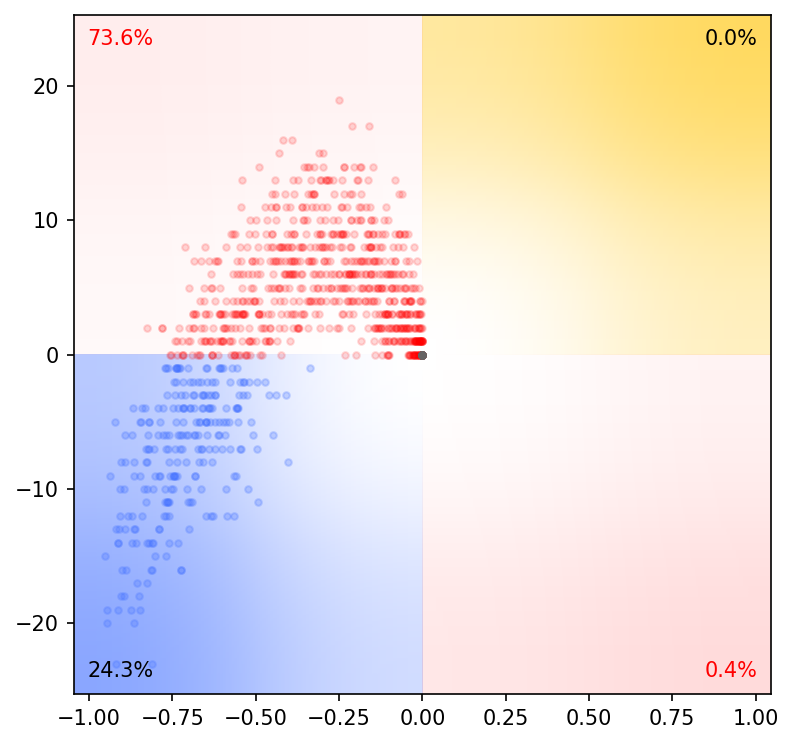

In [64]:
plt.figure(num=None, figsize=(6, 6), dpi=150, facecolor='w', edgecolor='k')
X = Synergism_abs
Y = Synergism_rich_abs
percentile = 100
observation_effect_plot(X, Y, percentile, 1, 1, 1)

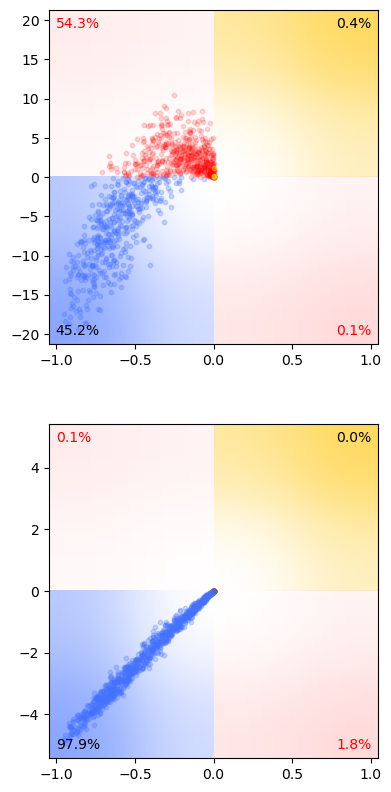

In [65]:
plt.figure(num=None, figsize=(4, 8), dpi=100, facecolor='w', edgecolor='k')

################################# Diversity #######################################

X = Synergism_abs
Y = Synergism_diversity_abs
percentile = 100
observation_effect_plot(X, Y, percentile, 2, 1, 1)


################################# Total Biomass #######################################

X = Synergism_abs
Y = Synergism_total_abs
percentile = 100
observation_effect_plot(X, Y, percentile, 2, 1, 2)

plt.tight_layout(pad=1, h_pad=4)



<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Figure 4: Distance and Function <a class="anchor" id="3"></a>
[Top](#1)


In [66]:
#### Stressor simulation parameters #### 
num_stress = 500                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 25                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


############## Across values of stressor direction ##############


sI_d = 1.5                                 
Synergism_abs1, _, _, Synergism_total_abs1, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
 
sI_d = 1.0                              
Synergism_abs2, _, _, Synergism_total_abs2, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)

sI_d = 0.5                                   
Synergism_abs3, _, _, Synergism_total_abs3, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)

sI_d = 0.0                                 
Synergism_abs4, _, _, Synergism_total_abs4, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)

sI_d = -0.5                                
Synergism_abs5, _, _, Synergism_total_abs5, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)

sI_d = -1.0                                 
Synergism_abs6, _, _, Synergism_total_abs6, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)

sI_d = -1.5                                  
Synergism_abs7, _, _, Synergism_total_abs7, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)




S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200


<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))


300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting s

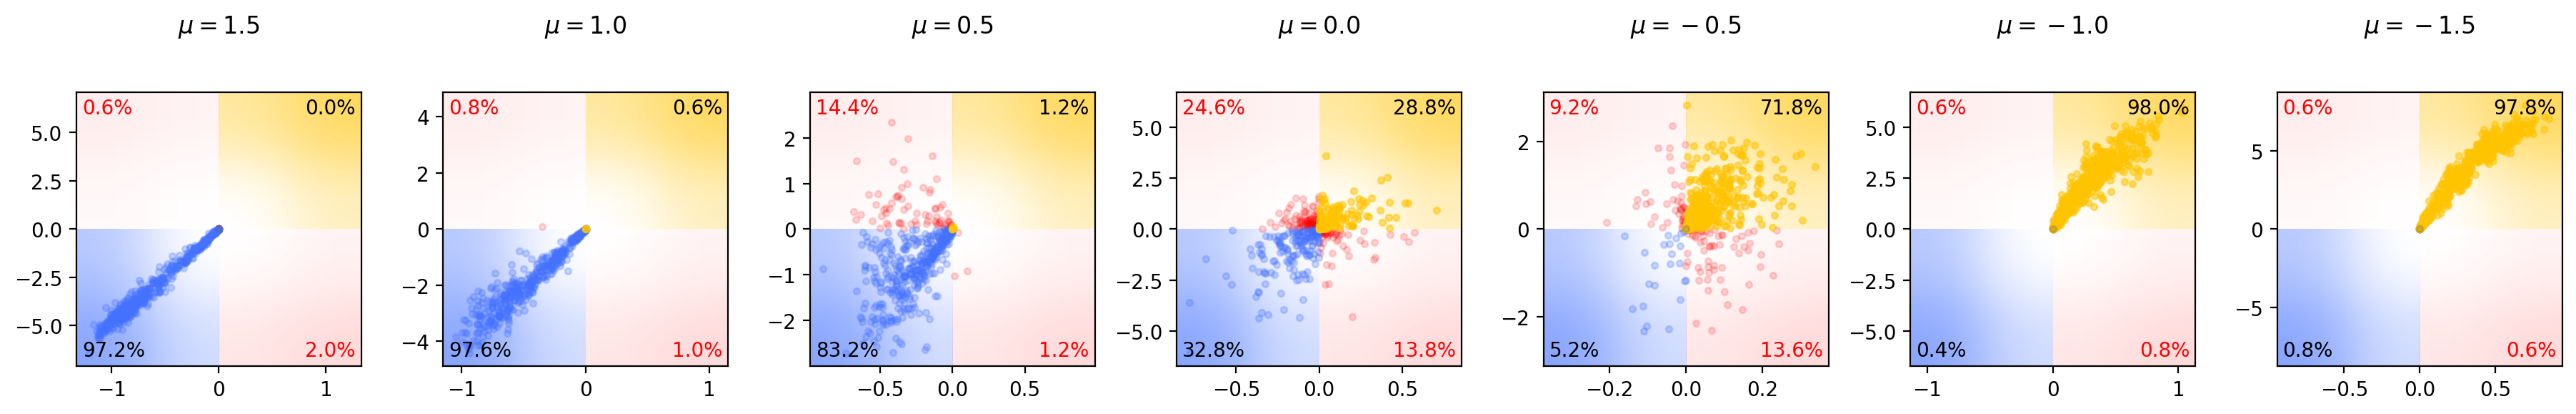

In [67]:
plt.figure(num=None, figsize=(18, 3), dpi=200, facecolor='w', edgecolor='k')

percentile = 100

X = Synergism_abs1
Y = Synergism_total_abs1
observation_effect_plot(X, Y, percentile, 1, 7, 1)
plt.title("$\mu = 1.5$", pad=30)

X = Synergism_abs2
Y = Synergism_total_abs2
observation_effect_plot(X, Y, percentile, 1, 7, 2)
plt.title("$\mu = 1.0$", pad=30)

X = Synergism_abs3
Y = Synergism_total_abs3
observation_effect_plot(X, Y, percentile, 1, 7, 3)
plt.title("$\mu = 0.5$", pad=30)

X = Synergism_abs4
Y = Synergism_total_abs4
observation_effect_plot(X, Y, percentile, 1, 7, 4)
plt.title("$\mu = 0.0$", pad=30)

X = Synergism_abs5
Y = Synergism_total_abs5
observation_effect_plot(X, Y, percentile, 1, 7, 5)
plt.title("$\mu = -0.5$", pad=30)

X = Synergism_abs6
Y = Synergism_total_abs6
observation_effect_plot(X, Y, percentile, 1, 7, 6)
plt.title("$\mu = -1.0$", pad=30)

X = Synergism_abs7
Y = Synergism_total_abs7
observation_effect_plot(X, Y, percentile, 1, 7, 7)
plt.title("$\mu = -1.5$", pad=30)

plt.tight_layout(w_pad=1, h_pad=1)

## Heatmaps

In [7]:
#### Stressor simulation parameters #### 
num_stress = 300                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
#cen = 0.                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
#inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                               # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 25                                    # intensity of sI effects
Type_I_rel = "true"                          # 'true' means that type I stressors are relative to rho




##################################################################################
###### stressor directions and fraction of invaders - axes of the heatmap ########

direction = [1.5, 1.25, 1., 0.75, 0.5, 0.25, 0., -0.25, -0.5, -0.75, -1., -1.25, -1.5]
fractions = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]

# finding the best mean for the growth rates to achieve desired fraction of invaders 
centers = [0.2, 0.17, 0.12, 0.11, 0.07, 0.03, 0., -0.03, -0.07, -0.11, -0.12, -0.17, -0.2]



# for sigma = 0
#centers = [0.2, 0.17, 0.12, 0.11, 0.07, 0.03, 0., -0.03, -0.07, -0.11, -0.12, -0.17, -0.2]
#fractions = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]



### To figure out the optimum parameters to achieve certain fractions of potential invaders 

#   S = 100
#   mu = 0.0 
#   sigma = 0.9 
#   zeta = 0.2
#   cen = -0.19

#   nb = 250 

#   richness = np.zeros(nb)

#   for n in range(nb): 
#       rho, Aij, Nf, persist = random_assembly(S, mu, sigma, zeta, cen)
#       richness[n] = len(persist)

#   plt.hist(richness,bins=100)
#   stats.mode(richness)


##################################################################################


# Function to calculate a row of correlation values (across stressor directions for a specific biomass center)

def row(centers, fractions):  
    cen = centers
    inv_frac = fractions
    i = -1
    row = np.zeros(len(direction))
    for n in direction:
        sI_d = n
        i = i + 1
        Synergism_abs, _, _, Synergism_total_abs, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
        row[i] = spearmanr(Synergism_abs, Synergism_total_abs)[0]
    return row
    

##################################################################################
# Run simulations for range of inv_frac (+ corresponding cen) for each stressor direction

A = row(centers[0], fractions[0])
B = row(centers[1], fractions[1])
C = row(centers[2], fractions[2])
D = row(centers[3], fractions[3])
E = row(centers[4], fractions[4])
F = row(centers[5], fractions[5])
G = row(centers[6], fractions[6])
H = row(centers[7], fractions[7])
I = row(centers[8], fractions[8])
J = row(centers[9], fractions[9])
K = row(centers[10], fractions[10])
L = row(centers[11], fractions[11])
M = row(centers[12], fractions[12])


##################################################################################
# Combine all the rows into a matrix called Cor (matrix of the heatmap)

Cor = np.array([
    
    M,
    L, 
    K,
    J,
    I, 
    H,
    G,
    F, 
    E,
    D,
    C, 
    B,
    A,

])

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  80 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  80 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  80 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species: 

Persisting species:  70 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  70 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  70 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  70 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stres

<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))


200
300
400

S:  100
zeta:  0.2
cen:  0.07
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  60 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.07
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  60 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.07
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  60 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.07
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Per

100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  50 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500


Persisting species:  40 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.11
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  35 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.11
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  35 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.11
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  35 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.11
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stre

Persisting species:  25 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.17
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  25 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.17
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  25 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.17
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  500

Persisting species:  25 / 100

0
100
200
300
400

S:  100
zeta:  0.2
cen:  -0.17
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of s

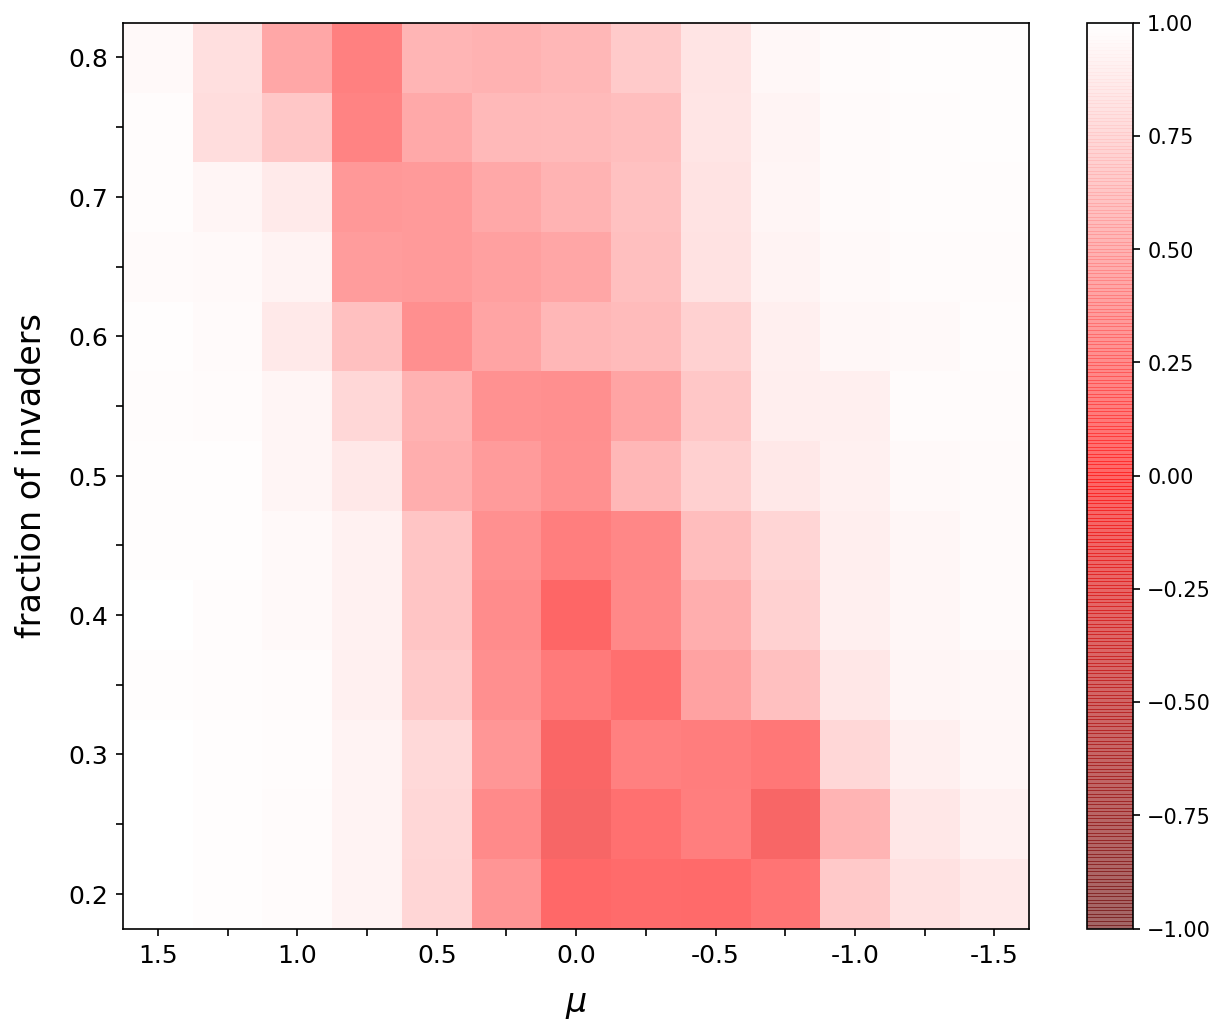

In [20]:
dark_red = (100/255, 0/255, 0/255)
red_grad2 = [dark_red, "red", "white"]
heatmap_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad2)


plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
image = plt.imshow(Cor, cmap=heatmap_cmap, alpha =0.6, interpolation='nearest', vmin=-1, vmax=1) 
plt.colorbar(image, label="")
plt.xticks(np.arange(13), fontsize = 12,
           labels = ("1.5", "", "1.0", "", "0.5", "", "0.0", "", "-0.5", "", "-1.0", "", "-1.5"))
plt.yticks(np.arange(13), fontsize = 12,
           labels = ("0.8", "", "0.7", "", "0.6", "", "0.5", "", "0.4", "", "0.3", "", "0.2"))
plt.xlabel("$\mu$", fontsize=16, labelpad=10)
plt.ylabel("fraction of invaders", fontsize=16, labelpad=10);

In [21]:
#### Stressor simulation parameters #### 
num_stress = 300                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
#sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho



###### axes of the heatmap ########
intensities = [10., 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40]
direction = [1.5, 1.25, 1., 0.75, 0.5, 0.25, 0., -0.25, -0.5, -0.75, -1., -1.25, -1.5]


# Function to calculate a row of correlation values (across stressor directions for a specific biomass center)

def row_int(intensities):  
    sI_i = intensities
    i = -1
    row = np.zeros(len(direction))
    for n in direction:
        sI_d = n
        i = i + 1
        Synergism_abs, _, _, Synergism_total_abs, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
        row[i] = spearmanr(Synergism_abs, Synergism_total_abs)[0]
    return row
    

# Each row from bottom to top - changing cen

A = row_int(intensities[0])
B = row_int(intensities[1])
C = row_int(intensities[2])
D = row_int(intensities[3])
E = row_int(intensities[4])
F = row_int(intensities[5])
G = row_int(intensities[6])
H = row_int(intensities[7])
I = row_int(intensities[8])
J = row_int(intensities[9])
K = row_int(intensities[10])
L = row_int(intensities[11])
M = row_int(intensities[12])


# Combine all the rows into a matrix called Cor 

Cor2 = np.array([
    
    M,
    L, 
    K,
    J,
    I, 
    H,
    G,
    F, 
    E,
    D,
    C, 
    B,
    A,

])

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.5 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.25 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community: 

<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))


Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.25 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  250

Pe

100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 30
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 30
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.25 +- 1
Type_I Intensity: 0 to 30
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.5 +- 1
Type_I Intensity: 0 to 30
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100



100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 37.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 37.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.25 +- 1
Type_I Intensity: 0 to 37.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.0 +- 1
Type_I Intensity: 0 to 37.5
Type I relative to rho

Number of stressor experiments per community:  250

Persisting species:  50 / 1

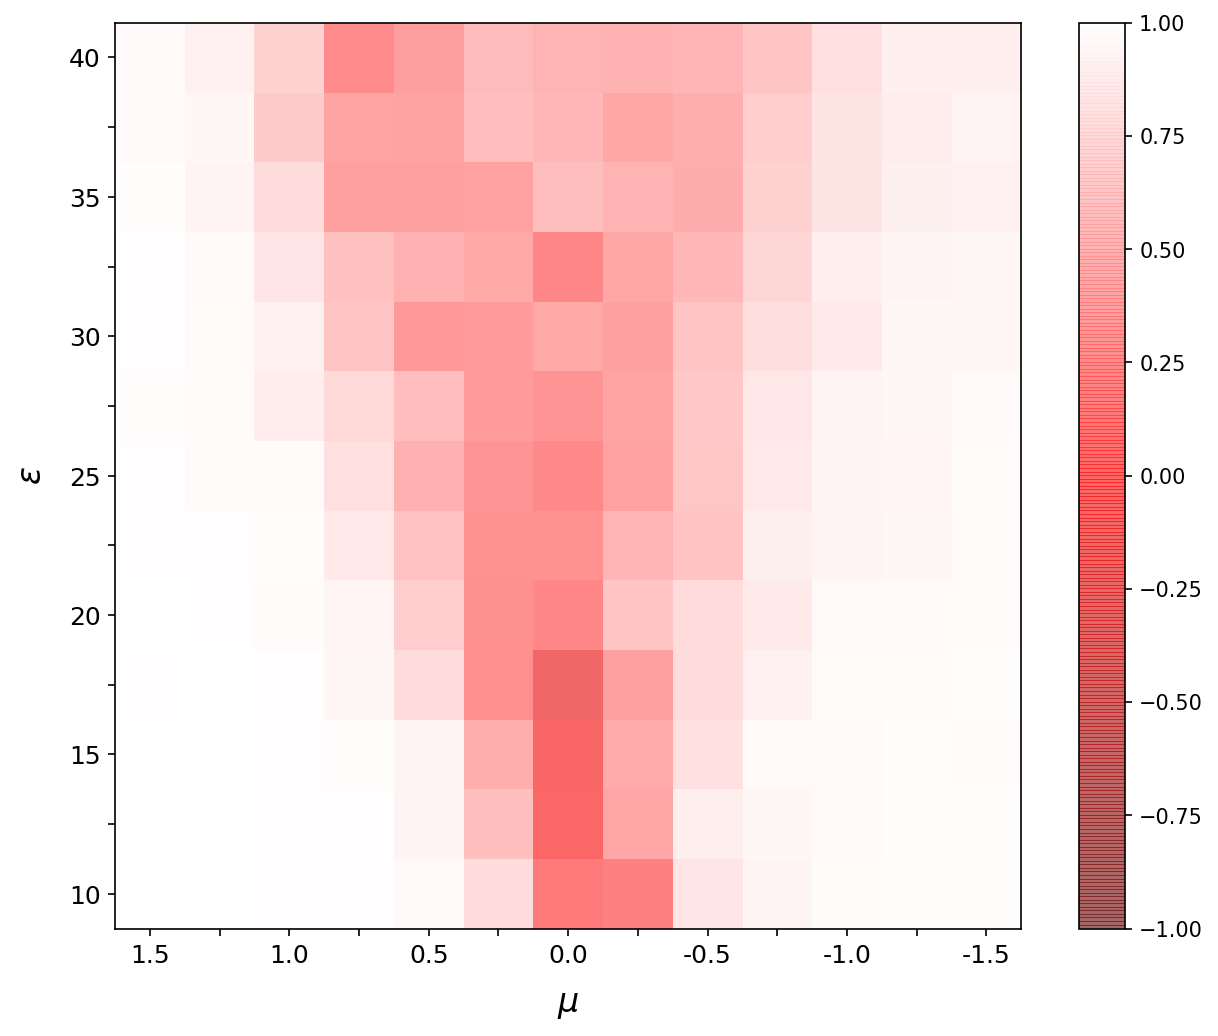

In [23]:
dark_red = (100/255, 0/255, 0/255)
red_grad2 = [dark_red, "red", "white"]
heatmap_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad2)


plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
image = plt.imshow(Cor2, cmap=heatmap_cmap, alpha =0.6, interpolation='nearest', vmin=-1, vmax=1) 
plt.colorbar(image, label="")
plt.xticks(np.arange(13), fontsize = 12,
           labels = ("1.5", "", "1.0", "", "0.5", "", "0.0", "", "-0.5", "", "-1.0", "", "-1.5"))
plt.yticks(np.arange(13), fontsize = 12,
           labels = ("40", "", "35", "", "30", "", "25", "", "20", "", "15", "", "10"))
plt.xlabel("$\mu$", fontsize=16, labelpad=10)
plt.ylabel("$\epsilon$", fontsize=16, labelpad=10);

<br>
<br>
<br>
<br>
<br>

## Figure 5: Diversity <a class="anchor" id="4"></a>
[Top](#1)

In [47]:
#### Stressor simulation parameters #### 
num_stress = 100                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.0                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
#sI_i = 25                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho



intensity = (10, 15, 20, 25, 30)
direction = (2, 1, 0, -1, -2)


def diversity_heatmap(direction, intensity):
    sI_d = direction
    sI_i = intensity
    _, _, _, _, syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
    
    ###### Option to remove inf values - how="any" - means that a row with any nas is removed
    dataframe = pd.DataFrame({'syn_hill_2':syn_hill_2, 
                          'syn_hill_3':syn_hill_3,
                          'syn_hill_4':syn_hill_4,
                          'syn_hill_5':syn_hill_5,
                          'syn_hill_6':syn_hill_6,
                          'syn_hill_7':syn_hill_7,
                          'syn_hill_8':syn_hill_8,
                          'syn_hill_9':syn_hill_9,
                          'syn_hill_10':syn_hill_10,})
    dataframe = dataframe.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    syn_hill_2 = dataframe.syn_hill_2.values
    syn_hill_3 = dataframe.syn_hill_3.values
    syn_hill_4 = dataframe.syn_hill_4.values
    syn_hill_5 = dataframe.syn_hill_5.values
    syn_hill_6 = dataframe.syn_hill_6.values
    syn_hill_7 = dataframe.syn_hill_7.values
    syn_hill_8 = dataframe.syn_hill_8.values
    syn_hill_9 = dataframe.syn_hill_9.values
    syn_hill_10 = dataframe.syn_hill_10.values

    hill_numbers = [syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10]
    n = -1
    cor = np.zeros(len(hill_numbers)**2)
    for i in hill_numbers:
        for j in hill_numbers:
            n = n + 1
            cor[n] = spearmanr(i, j)[0]
    Cor = cor.reshape(9, 9)
    return Cor
    

Cor00 = diversity_heatmap(direction[0], intensity[0])
Cor01 = diversity_heatmap(direction[0], intensity[1])
Cor02 = diversity_heatmap(direction[0], intensity[2])
Cor03 = diversity_heatmap(direction[0], intensity[3])
Cor04 = diversity_heatmap(direction[0], intensity[4])

Cor10 = diversity_heatmap(direction[1], intensity[0])
Cor11 = diversity_heatmap(direction[1], intensity[1])
Cor12 = diversity_heatmap(direction[1], intensity[2])
Cor13 = diversity_heatmap(direction[1], intensity[3])
Cor14 = diversity_heatmap(direction[1], intensity[4])

Cor20 = diversity_heatmap(direction[2], intensity[0])
Cor21 = diversity_heatmap(direction[2], intensity[1])
Cor22 = diversity_heatmap(direction[2], intensity[2])
Cor23 = diversity_heatmap(direction[2], intensity[3])
Cor24 = diversity_heatmap(direction[2], intensity[4])

Cor30 = diversity_heatmap(direction[3], intensity[0])
Cor31 = diversity_heatmap(direction[3], intensity[1])
Cor32 = diversity_heatmap(direction[3], intensity[2])
Cor33 = diversity_heatmap(direction[3], intensity[3])
Cor34 = diversity_heatmap(direction[3], intensity[4])

Cor40 = diversity_heatmap(direction[4], intensity[0])
Cor41 = diversity_heatmap(direction[4], intensity[1])
Cor42 = diversity_heatmap(direction[4], intensity[2])
Cor43 = diversity_heatmap(direction[4], intensity[3])
Cor44 = diversity_heatmap(direction[4], intensity[4])










S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 10
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0


<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))



S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 25
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 30
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1 +- 1
Type_I Intensity: 0 to 10
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  80 / 100

0

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma

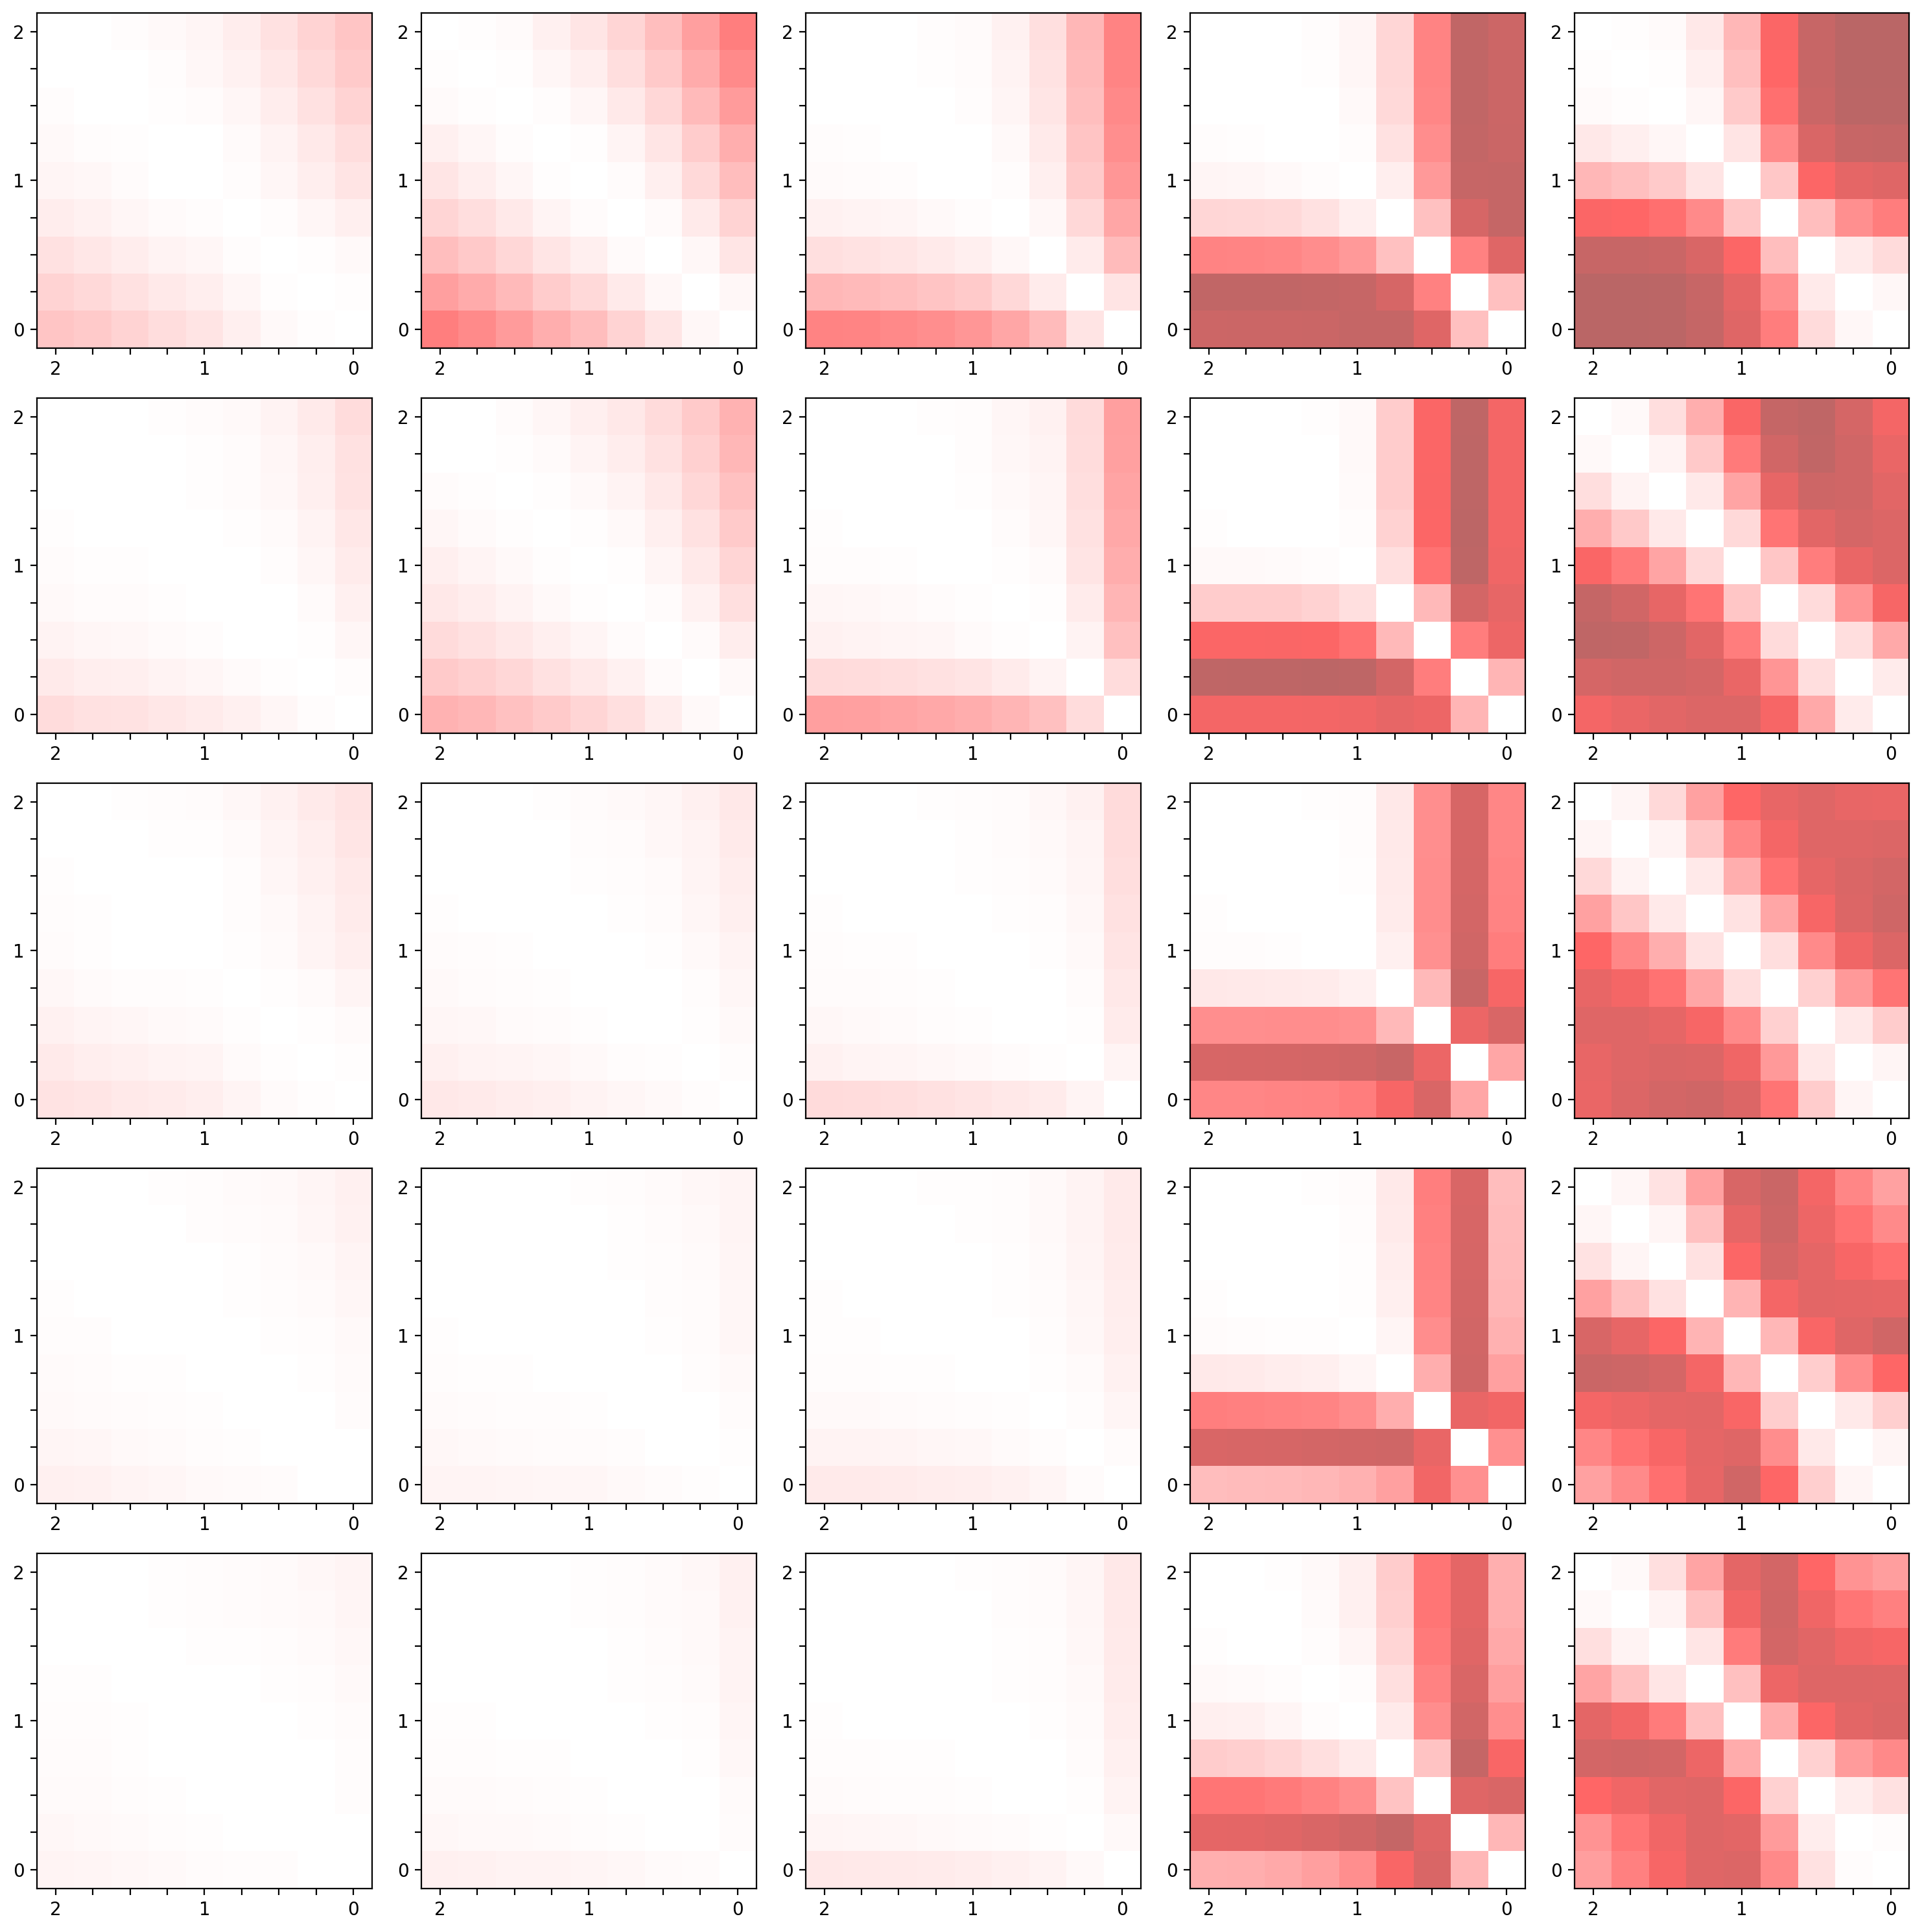

In [48]:
dark_red = (100/255, 0/255, 0/255)
red_grad2 = [dark_red, "red", "white"]
heatmap_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad2)

nums = ("2", "", "", "", "1", "", "", "", "0")

plt.figure(num=None, figsize=(15, 15), dpi=200, facecolor='w', edgecolor='k')


def plot_diversity_heatmap(r, c, n, Cor):
    plt.subplot(r, c, n)
    image = plt.imshow(Cor, cmap=heatmap_cmap, alpha =0.6, interpolation='nearest', vmin=-1, vmax=1) 
    plt.xticks(np.arange(9),
           labels = nums)
    plt.yticks(np.arange(9),
           labels = nums)

plot_diversity_heatmap(5, 5, 1, Cor00)
plot_diversity_heatmap(5, 5, 2, Cor10)
plot_diversity_heatmap(5, 5, 3, Cor20)
plot_diversity_heatmap(5, 5, 4, Cor30)
plot_diversity_heatmap(5, 5, 5, Cor40)

plot_diversity_heatmap(5, 5, 6, Cor01)
plot_diversity_heatmap(5, 5, 7, Cor11)
plot_diversity_heatmap(5, 5, 8, Cor21)
plot_diversity_heatmap(5, 5, 9, Cor31)
plot_diversity_heatmap(5, 5, 10, Cor41)

plot_diversity_heatmap(5, 5, 11, Cor02)
plot_diversity_heatmap(5, 5, 12, Cor12)
plot_diversity_heatmap(5, 5, 13, Cor22)
plot_diversity_heatmap(5, 5, 14, Cor32)
plot_diversity_heatmap(5, 5, 15, Cor42)

plot_diversity_heatmap(5, 5, 16, Cor03)
plot_diversity_heatmap(5, 5, 17, Cor13)
plot_diversity_heatmap(5, 5, 18, Cor23)
plot_diversity_heatmap(5, 5, 19, Cor33)
plot_diversity_heatmap(5, 5, 20, Cor43)

plot_diversity_heatmap(5, 5, 21, Cor04)
plot_diversity_heatmap(5, 5, 22, Cor14)
plot_diversity_heatmap(5, 5, 23, Cor24)
plot_diversity_heatmap(5, 5, 24, Cor34)
plot_diversity_heatmap(5, 5, 25, Cor44)

    
plt.tight_layout();

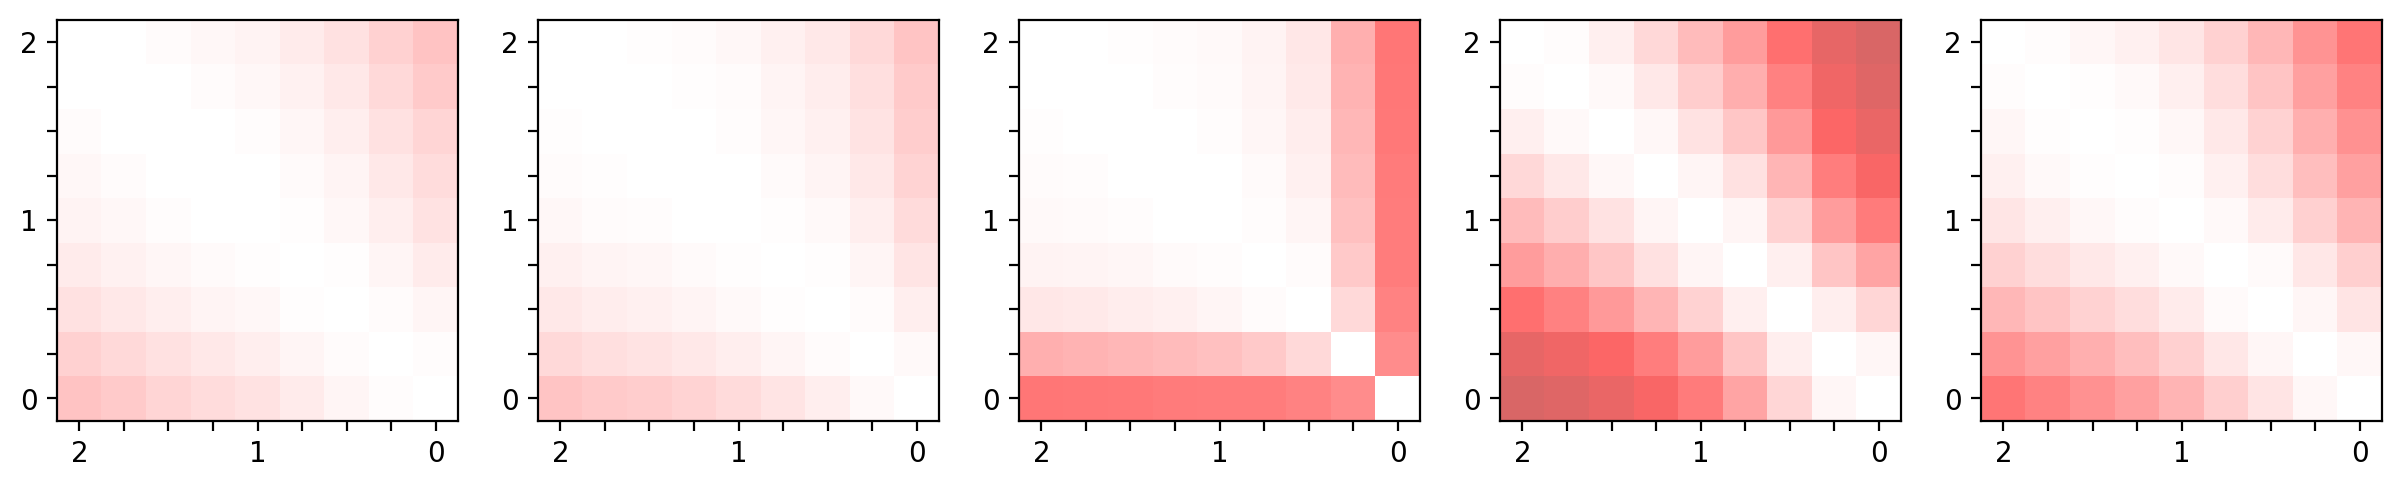

In [219]:
plt.figure(num=None, figsize=(15, 3), dpi=200, facecolor='w', edgecolor='k')


plot_diversity_heatmap(1, 5, 1, Cor01)
plot_diversity_heatmap(1, 5, 2, Cor11)
plot_diversity_heatmap(1, 5, 3, Cor21)
plot_diversity_heatmap(1, 5, 4, Cor31)
plot_diversity_heatmap(1, 5, 5, Cor41)

In [49]:
#### Stressor simulation parameters #### 
num_stress = 100                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
#cen = 0.0                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
#inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 15                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho



fraction = (0.7, 0.6, 0.5, 0.4, 0.3)
centers = (-0.12, -0.07, 0., 0.07, 0.12)
direction = (2, 1, 0, -1, -2)

#centers = [0.2, 0.17, 0.12, 0.11, 0.07, 0.03, 0., -0.03, -0.07, -0.11, -0.12, -0.17, -0.2]
#fractions = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]



def diversity_heatmap(direction, centers, fraction):
    sI_d = direction
    cen = centers
    inv_frac = fraction
    _, _, _, _, syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
    
    ###### Option to remove inf values - how="any" - means that a row with any nas is removed
    dataframe = pd.DataFrame({'syn_hill_2':syn_hill_2, 
                          'syn_hill_3':syn_hill_3,
                          'syn_hill_4':syn_hill_4,
                          'syn_hill_5':syn_hill_5,
                          'syn_hill_6':syn_hill_6,
                          'syn_hill_7':syn_hill_7,
                          'syn_hill_8':syn_hill_8,
                          'syn_hill_9':syn_hill_9,
                          'syn_hill_10':syn_hill_10,})
    dataframe = dataframe.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    syn_hill_2 = dataframe.syn_hill_2.values
    syn_hill_3 = dataframe.syn_hill_3.values
    syn_hill_4 = dataframe.syn_hill_4.values
    syn_hill_5 = dataframe.syn_hill_5.values
    syn_hill_6 = dataframe.syn_hill_6.values
    syn_hill_7 = dataframe.syn_hill_7.values
    syn_hill_8 = dataframe.syn_hill_8.values
    syn_hill_9 = dataframe.syn_hill_9.values
    syn_hill_10 = dataframe.syn_hill_10.values

    hill_numbers = [syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10]
    n = -1
    cor = np.zeros(len(hill_numbers)**2)
    for i in hill_numbers:
        for j in hill_numbers:
            n = n + 1
            cor[n] = spearmanr(i, j)[0]
    Cor = cor.reshape(9, 9)
    return Cor
    

Cor00 = diversity_heatmap(direction[0], centers[0], fraction[0])
Cor01 = diversity_heatmap(direction[0], centers[1], fraction[1])
Cor02 = diversity_heatmap(direction[0], centers[2], fraction[2])
Cor03 = diversity_heatmap(direction[0], centers[3], fraction[3])
Cor04 = diversity_heatmap(direction[0], centers[4], fraction[4])

Cor10 = diversity_heatmap(direction[1], centers[0], fraction[0])
Cor11 = diversity_heatmap(direction[1], centers[1], fraction[1])
Cor12 = diversity_heatmap(direction[1], centers[2], fraction[2])
Cor13 = diversity_heatmap(direction[1], centers[3], fraction[3])
Cor14 = diversity_heatmap(direction[1], centers[4], fraction[4])

Cor20 = diversity_heatmap(direction[2], centers[0], fraction[0])
Cor21 = diversity_heatmap(direction[2], centers[1], fraction[1])
Cor22 = diversity_heatmap(direction[2], centers[2], fraction[2])
Cor23 = diversity_heatmap(direction[2], centers[3], fraction[3])
Cor24 = diversity_heatmap(direction[2], centers[4], fraction[4])

Cor30 = diversity_heatmap(direction[3], centers[0], fraction[0])
Cor31 = diversity_heatmap(direction[3], centers[1], fraction[1])
Cor32 = diversity_heatmap(direction[3], centers[2], fraction[2])
Cor33 = diversity_heatmap(direction[3], centers[3], fraction[3])
Cor34 = diversity_heatmap(direction[3], centers[4], fraction[4])

Cor40 = diversity_heatmap(direction[4], centers[0], fraction[0])
Cor41 = diversity_heatmap(direction[4], centers[1], fraction[1])
Cor42 = diversity_heatmap(direction[4], centers[2], fraction[2])
Cor43 = diversity_heatmap(direction[4], centers[3], fraction[3])
Cor44 = diversity_heatmap(direction[4], centers[4], fraction[4])












S:  100
zeta:  0.2
cen:  -0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  30 / 100

0


<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))



S:  100
zeta:  0.2
cen:  -0.07
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  40 / 100

0

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  50 / 100

0

S:  100
zeta:  0.2
cen:  0.07
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  60 / 100

0

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 2 +- 1
Type_I Intensity: 0 to 15
Type I relative to rho

Number of stressor experiments per community:  100

Persisting species:  70 / 100

0

S:  100
zeta:  0.2
cen:  -0.12
mu:  0.0

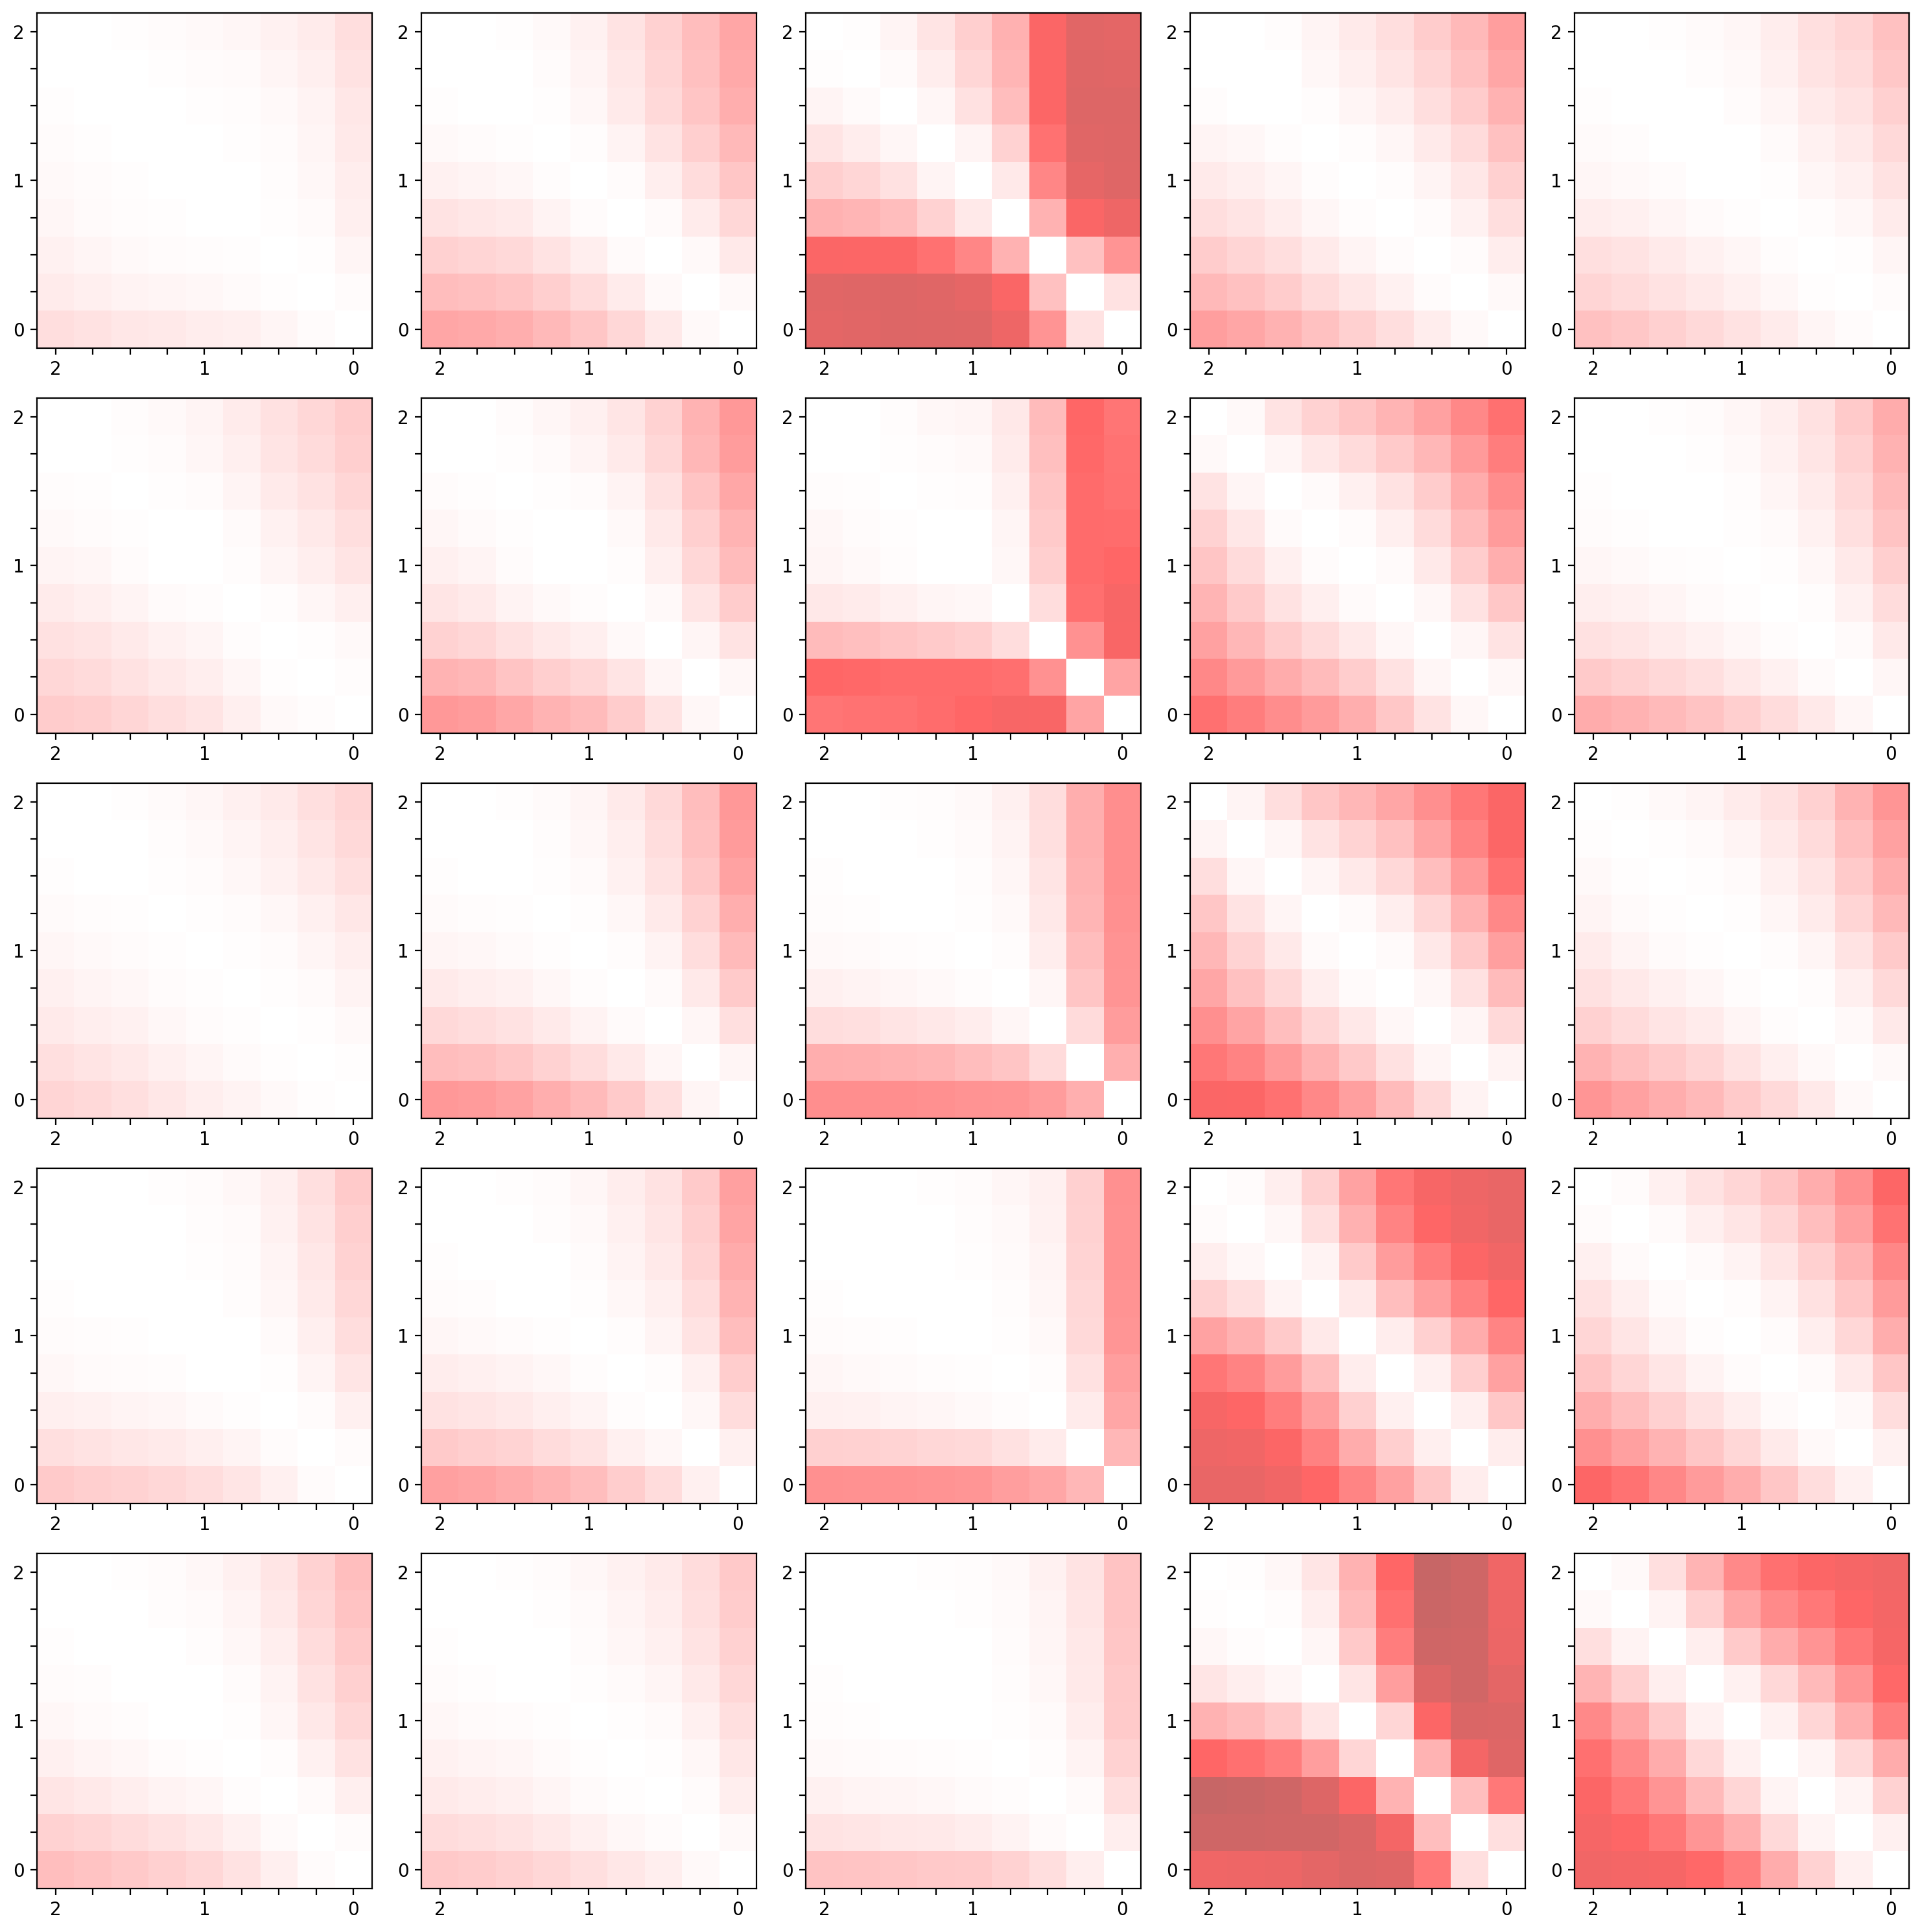

In [50]:
dark_red = (100/255, 0/255, 0/255)
red_grad2 = [dark_red, "red", "white"]
heatmap_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad2)

nums = ("2", "", "", "", "1", "", "", "", "0")

plt.figure(num=None, figsize=(15, 15), dpi=200, facecolor='w', edgecolor='k')


def plot_diversity_heatmap(r, c, n, Cor):
    plt.subplot(r, c, n)
    image = plt.imshow(Cor, cmap=heatmap_cmap, alpha =0.6, interpolation='nearest', vmin=-1, vmax=1) 
    plt.xticks(np.arange(9),
           labels = nums)
    plt.yticks(np.arange(9),
           labels = nums)

plot_diversity_heatmap(5, 5, 1, Cor00)
plot_diversity_heatmap(5, 5, 2, Cor10)
plot_diversity_heatmap(5, 5, 3, Cor20)
plot_diversity_heatmap(5, 5, 4, Cor30)
plot_diversity_heatmap(5, 5, 5, Cor40)

plot_diversity_heatmap(5, 5, 6, Cor01)
plot_diversity_heatmap(5, 5, 7, Cor11)
plot_diversity_heatmap(5, 5, 8, Cor21)
plot_diversity_heatmap(5, 5, 9, Cor31)
plot_diversity_heatmap(5, 5, 10, Cor41)

plot_diversity_heatmap(5, 5, 11, Cor02)
plot_diversity_heatmap(5, 5, 12, Cor12)
plot_diversity_heatmap(5, 5, 13, Cor22)
plot_diversity_heatmap(5, 5, 14, Cor32)
plot_diversity_heatmap(5, 5, 15, Cor42)

plot_diversity_heatmap(5, 5, 16, Cor03)
plot_diversity_heatmap(5, 5, 17, Cor13)
plot_diversity_heatmap(5, 5, 18, Cor23)
plot_diversity_heatmap(5, 5, 19, Cor33)
plot_diversity_heatmap(5, 5, 20, Cor43)

plot_diversity_heatmap(5, 5, 21, Cor04)
plot_diversity_heatmap(5, 5, 22, Cor14)
plot_diversity_heatmap(5, 5, 23, Cor24)
plot_diversity_heatmap(5, 5, 24, Cor34)
plot_diversity_heatmap(5, 5, 25, Cor44)

    
plt.tight_layout();

<br>
<br>
<br>
<br>
<br>

## Sup Figure: Intensity <a class="anchor" id="5"></a>
[Top](#1)

In [16]:
#### Stressor simulation parameters #### 
num_stress = 1000                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
sI_d = 0.75                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 30                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho


#### Run the stressor simulations ####
Synergism_abs, Synergism_rich_abs, Synergism_diversity_abs, Synergism_total_abs, syn_hill_2, syn_hill_3, syn_hill_4, syn_hill_5, syn_hill_6, syn_hill_7, syn_hill_8, syn_hill_9, syn_hill_10, mean_cos, intensity = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)




S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 30
Type I relative to rho

Number of stressor experiments per community:  1000

Persisting species:  50 / 100

0
100
200
300
400
500
600
700
800
900



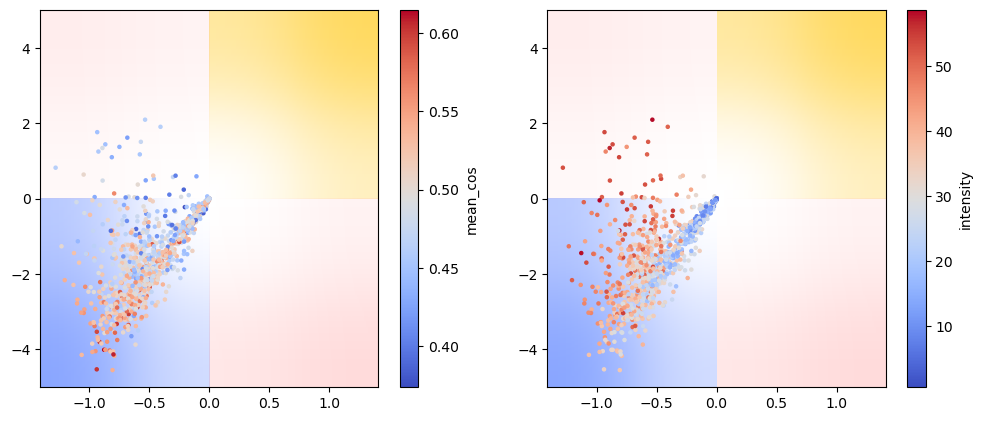

In [17]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')

X = Synergism_abs
Y = Synergism_total_abs


Z = mean_cos
observation_effect_plot_2(X, Y, Z, 100, 1, 2, 1) 
cbar= plt.colorbar()
cbar.ax.tick_params(labelsize=10) 
cbar.set_label('mean_cos')



Z = intensity
observation_effect_plot_2(X, Y, Z, 100, 1, 2, 2) 
cbar= plt.colorbar()
cbar.ax.tick_params(labelsize=10) 
cbar.set_label('intensity')




<br>
<br>
<br>
<br>
<br>

## Sup Figure: Distance-Diversity <a class="anchor" id="6"></a>
[Top](#1)

In [24]:
#### Stressor simulation parameters #### 
num_stress = 300                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
#cen = 0.                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
#inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
sI_i = 20                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho





##################################################################################
###### stressor directions and fraction of invaders - axes of the heatmap ########

direction = [1.5, 1.25, 1., 0.75, 0.5, 0.25, 0., -0.25, -0.5, -0.75, -1., -1.25, -1.5]
fractions = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]

# finding the best mean for the growth rates to achieve desired fraction of invaders 
centers = [0.2, 0.17, 0.12, 0.11, 0.07, 0.03, 0., -0.03, -0.07, -0.11, -0.12, -0.17, -0.2]



# for sigma = 0
#centers = [0.2, 0.17, 0.12, 0.11, 0.07, 0.03, 0., -0.03, -0.07, -0.11, -0.12, -0.17, -0.2]
# for sigma = 0.9
#centers = [0.5, 0.5, 0.2, 0.12, 0.05, 0.03, 0.0, 0.0, -0.03, -0.05, -0.1, -0.15, -0.18]

##################################################################################


# Function to calculate a row of correlation values (across stressor directions for a specific biomass center)

def row(centers, fractions):  
    cen = centers
    inv_frac = fractions
    i = -1
    row = np.zeros(len(direction))
    for n in direction:
        sI_d = n
        i = i + 1
        Synergism_abs, _, Synergism_diversity_abs, _, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
        row[i] = spearmanr(Synergism_abs, Synergism_diversity_abs)[0]
    return row
   

##################################################################################
# Run simulations for range of inv_frac (+ corresponding cen) for each stressor direction

A = row(centers[0], fractions[0])
B = row(centers[1], fractions[1])
C = row(centers[2], fractions[2])
D = row(centers[3], fractions[3])
E = row(centers[4], fractions[4])
F = row(centers[5], fractions[5])
G = row(centers[6], fractions[6])
H = row(centers[7], fractions[7])
I = row(centers[8], fractions[8])
J = row(centers[9], fractions[9])
K = row(centers[10], fractions[10])
L = row(centers[11], fractions[11])
M = row(centers[12], fractions[12])


##################################################################################
# Combine all the rows into a matrix called Cor (matrix of the heatmap)

Cor3 = np.array([
    
    M,
    L, 
    K,
    J,
    I, 
    H,
    G,
    F, 
    E,
    D,
    C, 
    B,
    A,

])

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.5 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  80 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  80 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  80 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  80 / 100

0
100
200

S:

Persisting species:  70 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.25 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  70 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  70 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  70 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community: 

Persisting species:  55 / 100

0
100
200


<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))



S:  100
zeta:  0.2
cen:  0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  55 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  55 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  55 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  55 / 100

0
100
20

Persisting species:  45 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  45 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  45 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  45 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.03
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.25 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per communi

Persisting species:  30 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  30 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  30 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  30 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.12
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.25 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community: 

100
200

S:  100
zeta:  0.2
cen:  -0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  20 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  20 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.25 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  20 / 100

0
100
200

S:  100
zeta:  0.2
cen:  -0.2
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.5 +- 1
Type_I Intensity: 0 to 20
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  20 / 1

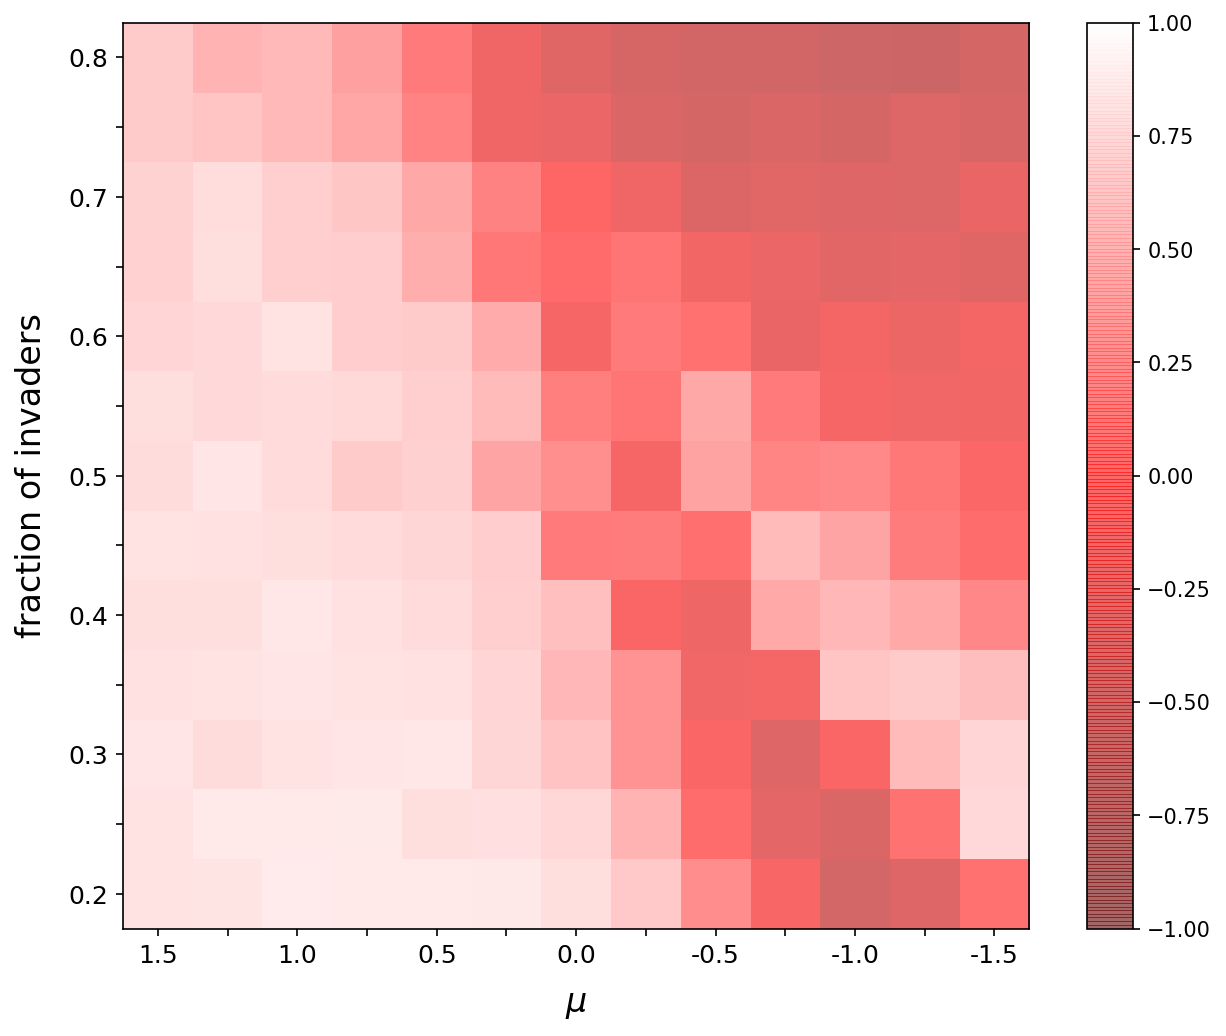

In [25]:
dark_red = (100/255, 0/255, 0/255)
red_grad2 = [dark_red, "red", "white"]
heatmap_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad2)


plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
image = plt.imshow(Cor3, cmap=heatmap_cmap, alpha =0.6, interpolation='nearest', vmin=-1, vmax=1) 
plt.colorbar(image, label="")
plt.xticks(np.arange(13), fontsize = 12,
           labels = ("1.5", "", "1.0", "", "0.5", "", "0.0", "", "-0.5", "", "-1.0", "", "-1.5"))
plt.yticks(np.arange(13), fontsize = 12,
           labels = ("0.8", "", "0.7", "", "0.6", "", "0.5", "", "0.4", "", "0.3", "", "0.2"))
plt.xlabel("$\mu$", fontsize=16, labelpad=10)
plt.ylabel("fraction of invaders", fontsize=16, labelpad=10);

In [26]:
#### Stressor simulation parameters #### 
num_stress = 300                           # Number of stressor simulations

#### Community parameters ####
S = 100                                    # Number of species    
zeta = 0.2                                # Scaling carrying capacity (rho)
cen = 0.                                  # Center of the biomass distribution (0 means 50% of species in pool will assemble)
mu = 0.0                                  # Mean interaction strength  
sigma = 0.0                               # Distribution of interaction strengths

#### Option to force fraction of invaders ####
inv_frac = 0.5                            # "nope" meansuse regular random assembly. Otherwise, modified random assembly will be run with the fraction of invaders provided (e.g 0.5)

#### System type #### 
system = "open"                             # "closed" means there will be no invasions

#### Stressor type I effects ####
Type_I = "all"                              # "neg"/"pos"/"no" means that type I stressors are always negative/positive/excluded (else unbiased)
#sI_d = 0                                    # negative values skew towards positive stressors, positive values skew towards negative stressors. stressors drawn from np.random.normal(sI_d, 1)
#sI_i = 2                                    # intensity of sI effects
Type_I_rel = "true"                         # 'true' means that type I stressors are relative to rho



###### axes of the heatmap ########
intensities = [5, 7.5, 10., 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
direction = [1.5, 1.25, 1., 0.75, 0.5, 0.25, 0., -0.25, -0.5, -0.75, -1., -1.25, -1.5]



# Function to calculate a row of correlation values (across stressor directions for a specific biomass center)

def row_int(intensities):  
    sI_i = intensities
    i = -1
    row = np.zeros(len(direction))
    for n in direction:
        sI_d = n
        i = i + 1
        Synergism_abs, _, Synergism_diversity_abs, _, _, _, _, _, _, _, _, _, _, _, _ = stressor_experiment(num_stress, S, zeta, cen, mu, sigma, system,Type_I, sI_d, sI_i, Type_I_rel, inv_frac)
        row[i] = spearmanr(Synergism_abs, Synergism_diversity_abs)[0]
    return row
    

# Each row from bottom to top - changing cen

A = row_int(intensities[0])
B = row_int(intensities[1])
C = row_int(intensities[2])
D = row_int(intensities[3])
E = row_int(intensities[4])
F = row_int(intensities[5])
G = row_int(intensities[6])
H = row_int(intensities[7])
I = row_int(intensities[8])
J = row_int(intensities[9])
K = row_int(intensities[10])
L = row_int(intensities[11])
M = row_int(intensities[12])


# Combine all the rows into a matrix called Cor 

Cor4 = np.array([
    
    M,
    L, 
    K,
    J,
    I, 
    H,
    G,
    F, 
    E,
    D,
    C, 
    B,
    A,

])

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.5 +- 1
Type_I Intensity: 0 to 5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  10

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.25 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 10.0
Type I relative to rho

Number of stressor experiments per communi

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.25 +- 1
Type_I Intensity: 0 to 17.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 17.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 17.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 17.5
Type I relative to rho

Number of stressor experiments per community: 

100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.5 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.25 +- 1
Type_I Intensity: 0 to 22.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50

<ipython-input-4-8221e597f18f>:26: RuntimeWarning: divide by zero encountered in power
  return np.power(norm(p, q), q/(1.-q))



S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 1.0 +- 1
Type_I Intensity: 0 to 27.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.75 +- 1
Type_I Intensity: 0 to 27.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.5 +- 1
Type_I Intensity: 0 to 27.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: 0.25 +- 1
Type_I Intensity: 0 to 27.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
10

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -0.75 +- 1
Type_I Intensity: 0 to 32.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.0 +- 1
Type_I Intensity: 0 to 32.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.25 +- 1
Type_I Intensity: 0 to 32.5
Type I relative to rho

Number of stressor experiments per community:  300

Persisting species:  50 / 100

0
100
200

S:  100
zeta:  0.2
cen:  0.0
mu:  0.0
sigma:  0.0
System: Open

Type I: Mixed
Type_I Direction: -1.5 +- 1
Type_I Intensity: 0 to 32.5
Type I relative to rho

Number of stressor experiments per communi

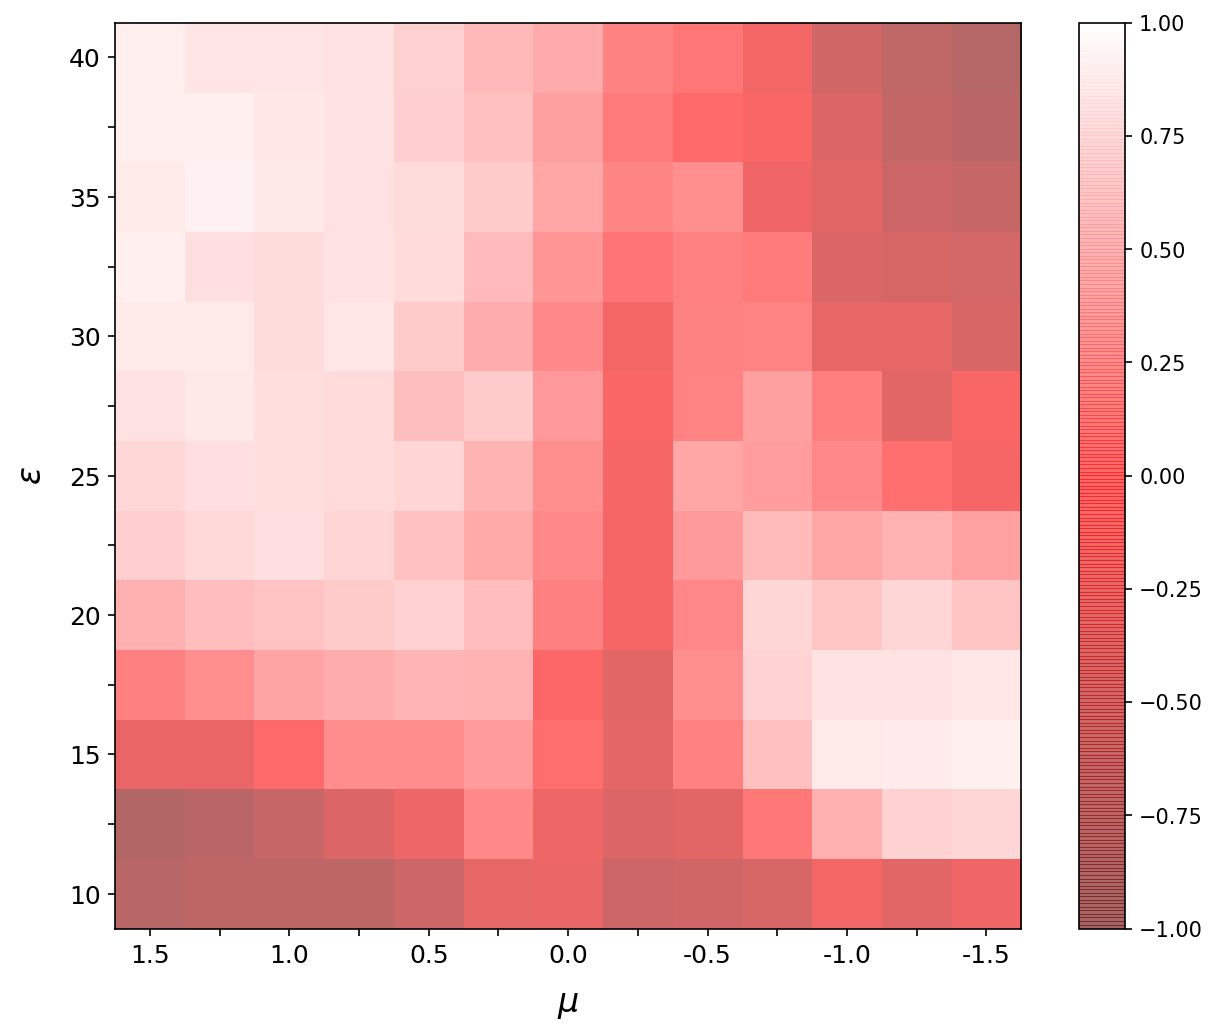

In [27]:
dark_red = (100/255, 0/255, 0/255)
red_grad2 = [dark_red, "red", "white"]
heatmap_cmap = LinearSegmentedColormap.from_list("mycmap", red_grad2)


plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
image = plt.imshow(Cor4, cmap=heatmap_cmap, alpha =0.6, interpolation='nearest', vmin=-1, vmax=1) 
plt.colorbar(image, label="")
plt.xticks(np.arange(13), fontsize = 12,
           labels = ("1.5", "", "1.0", "", "0.5", "", "0.0", "", "-0.5", "", "-1.0", "", "-1.5"))
plt.yticks(np.arange(13), fontsize = 12,
           labels = ("40", "", "35", "", "30", "", "25", "", "20", "", "15", "", "10"))
plt.xlabel("$\mu$", fontsize=16, labelpad=10)
plt.ylabel("$\epsilon$", fontsize=16, labelpad=10);

[Top](#1)